### Intro

**Used Car Price Prediction**

The used car market is growing rapidly, with millions of transactions happening every year. Given the sheer volume of cars available, determining the appropriate price for a used car can be quite challenging. Prices are influenced by various factors such as brand, model, year, mileage, fuel type, and accident history, among others.

Accurately estimating the price of a used car is crucial for both sellers and buyers. However, manually analyzing all these factors to set the right price is time-consuming. This is where Artificial Intelligence (AI) comes into play.

This notebook focuses on predicting the price of used cars based on various features. By utilizing Exploratory Data Analysis (EDA) and Neural Networks (NN), we aim to build a solution for this regression problem. This notebook is designed to serve as a comprehensive guide, providing a step-by-step walkthrough of the entire process.


**Ultimate Guide to Used Car Price Prediction**

In this notebook, we will walk through the complete pipeline for predicting used car prices. The goal is to create an end-to-end guide that covers all essential steps, including:

- **Exploratory Data Analysis (EDA):** Understanding the data, visualizing relationships, and uncovering patterns.
- **Neural Networks (NN):** Utilizing deep learning techniques to enhance model performance.

## [2] Data Overview

**Column Descriptions**

| Column        | Description                                                        |
|---------------|--------------------------------------------------------------------|
| **id**        | Unique identifier for each car                                     |
| **brand**     | The brand or manufacturer of the car                               |
| **model**     | The specific model of the car                                      |
| **model_year**| The year the car model was manufactured                            |
| **milage**    | The total distance the car has traveled (in kilometers/miles)      |
| **fuel_type** | The type of fuel the car uses (e.g., petrol, diesel, electric)     |
| **engine**    | Engine capacity, typically measured in liters                      |
| **transmission**| The type of transmission (e.g., manual, automatic)               |
| **ext_col**   | The exterior color of the car                                      |
| **int_col**   | The interior color of the car                                      |
| **accident**  | Whether the car has been involved in an accident           |
| **clean_title**| Whether the car has a clean title (i.e., no legal issues related to ownership) |
| **price**     | The target variable representing the car's price                   |


In [ ]:
!pip install ppscore


  Using cached pandas-1.5.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached pandas-1.5.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.3
    Uninstalling pandas-2.2.3:
      Successfully uninstalled pandas-2.2.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.1.4, but you have pandas 1.5.3 which is incompatible.
mizani 0.11.4 requires pandas>=2.1.0, but you have pandas 1.5.3 which is incompatible.
plotnine 0.13.6 requires pandas<3.0.0,>=2.1.0, but you have pandas 1.5.3 which is incompatible.
visions 0.7.6 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.
xarray 2024.9

In [ ]:
!pip install ydata-profiling

  Using cached pandas-2.2.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
Using cached pandas-2.2.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.1 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 2.2.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.1.4, but you have pandas 2.2.3 which is incompatible.
ppscore 1.3.0 requires pandas<2.0.0,>=1.0.0, but you have pandas 2.2.3 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.stats import shapiro
import ppscore as pps
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer
import os

### Script

In [ ]:
def to_lowercase_and_strip(df):
        """
        Convert all string values in the DataFrame to lowercase and strip leading/trailing spaces.
        """
        for col in df.select_dtypes(include='object').columns:
            df[col] = df[col].apply(
                lambda x: x.lower().strip() if isinstance(x, str) else x
            )

        print(f"Columns {df.select_dtypes(include='object').columns} converted to lowercase and stripped.")

def unique_values_explicit(df, max_unique_values=1000):
    """
    Prints a limited number of unique values for each categorical column in the DataFrame.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - max_unique_values (int): The maximum number of unique values to display for each column.
    """
    # Create local variables for numeric and categorical DataFrames
    numeric_df = df.select_dtypes(include=np.number)
    categorical_df = df.select_dtypes(include='object')

    # Iterate over each column in the categorical DataFrame
    for column in categorical_df.columns:
        unique_values = categorical_df[column].unique()
        if len(unique_values) > max_unique_values:
            unique_values = unique_values[:max_unique_values]  # Limit to max_unique_values
        print(f"Unique values in `{column}` column (limited to {max_unique_values}):\n", unique_values, "\n")

def missing_values(df):
    """Mostra il numero di valori mancanti per ciascuna colonna."""
    missing = pd.DataFrame({
    'Count':df.isnull().sum()[df.isnull().sum()>0],
    'Percentage':(df.isnull().sum()[df.isnull().sum()>0]/df.shape[0])
    *100})
    print("Valori mancanti per colonna:\n", missing)

def unique_values(df):
    """Mostra il numero di valori unici per ciascuna colonna."""
    categorical_df = df.select_dtypes(include='object')
    unique = categorical_df.nunique()
    print("Unique categorical values:\n", unique)

def drop_columns(df, columns):
    """Rimuove le colonne specificate dal DataFrame."""
    df.drop(columns, axis=1, inplace=True)
    print(f"Colonne rimosse: {columns}")

def handle_missing_values(df, column_name: str, strategy='mean', fill_value=None, n_neighbors=5):
    """
    Handles missing values in a specified column of the DataFrame using the chosen strategy:
    - 'mean': fills with the mean
    - 'median': fills with the median
    - 'mode': fills with the mode
    - 'knn': uses KNN for imputation
    """
    if strategy in ['mean', 'median', 'most_frequent']:
        imputer = SimpleImputer(strategy=strategy, fill_value=fill_value)
        df[column_name] = imputer.fit_transform(df[[column_name]])
    elif strategy == 'mode':
        mode_value = df[column_name].mode()[0]
        df[column_name] = df[column_name].fillna(mode_value)  # Avoiding inplace=True
    elif strategy == 'knn':
        knn_imputer = KNNImputer(n_neighbors=n_neighbors)
        df[column_name] = knn_imputer.fit_transform(df[[column_name]])
    else:
        raise ValueError("Unsupported strategy. Choose from 'mean', 'median', 'mode', 'knn'.")

    print(f"Missing values in column '{column_name}' handled using the strategy: {strategy}")

    # Verify that there are no remaining missing values in the specified column
    if df[column_name].isnull().sum() == 0:
        print(f"No missing values remain in column '{column_name}'.")
    else:
        print(f"Warning: There are still missing values in column '{column_name}'.")

    return df

def split_engine_column(df, engine_col: str = 'engine'):
        """
        Splits the 'engine' column into multiple features: horsepower, displacement, cylinders, fuel_type_2, and engine_type.

        Parameters:
            engine_col (str): Name of the engine column to split (default is 'engine').

        Returns:
            None: Updates self.df with the new columns for horsepower, displacement, cylinders, fuel_type_2, and engine_type.
        """
        # Ensure the column exists
        if engine_col not in df.columns:
            raise ValueError(f"Column '{engine_col}' not found in DataFrame.")

        # Create new columns using regex extraction for lowercase strings
        df['horsepower'] = df[engine_col].str.extract(r'(\d+\.?\d*)hp', expand=False)
        df['displacement'] = df[engine_col].str.extract(r'(\d+\.?\d*)l', expand=False)
        df['cylinders'] = df[engine_col].str.extract(r'(\d+) cylinder', expand=False)
        df['fuel_type_2'] = df[engine_col].str.extract(r'(gasoline fuel|electric/gas|hybrid|flex fuel capability|plug-in electric/gas)', expand=False)
        df['engine_type'] = df[engine_col].str.extract(r'(turbo|gdi|dohc|v6|i4)', expand=False)

        # Convert numerical columns to floats
        df['horsepower'] = df['horsepower'].astype(float, errors='ignore')
        df['displacement'] = df['displacement'].astype(float, errors='ignore')
        df['cylinders'] = df['cylinders'].astype(float, errors='ignore')

        # Ensure all string columns are in lowercase
        for col in ['fuel_type_2', 'engine_type']:
            df[col] = df[col].str.lower()

        print("Engine column split into horsepower, displacement, cylinders, fuel_type_2, and engine_type.")

        # Drop the original 'engine' column
        df.drop(engine_col, axis=1, inplace=True)

        print("Original 'engine' column dropped, and numeric/categorical DataFrames updated.")

def replace_missing_fuel_type(df):
    """
    Replaces missing values in 'fuel_type' with corresponding values from 'fuel_type_2'
    and replaces '–' or 'not supported' with appropriate values.
    """
    # Replace NaN or '–' in 'fuel_type' with values from 'fuel_type_2'
    df['fuel_type'] = df.apply(
        lambda row: row['fuel_type_2'] if pd.isna(row['fuel_type']) or row['fuel_type'] in ['–', 'not supported']
        else row['fuel_type'],
        axis=1
    )

    print(test_clean['fuel_type'].unique())


def standardize_fuel_types(df):
    """
    Standardizes fuel types in the 'fuel_type' column based on a mapping.

    Parameters:
        df (pd.DataFrame): DataFrame containing the 'fuel_type' column.

    Returns:
        pd.DataFrame: DataFrame with updated 'fuel_type' column.
    """
    # Define the replacement mapping for common types
    fuel_type_replacements = {
        'gasoline fuel': 'gasoline',
        'e85 flex fuel': 'flex fuel',
        'flex fuel capability': 'flex fuel',
        'plug-in electric/gas': 'plug-in hybrid',
        'plug-in hybrid': 'plug-in hybrid',
        '–': np.nan,
        'not supported': np.nan
    }

    # Apply the replacement mapping
    df['fuel_type'] = df['fuel_type'].replace(fuel_type_replacements)

    print("Fuel types have been standardized.")
    print(df['fuel_type'].unique())







### Standardize data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/MIT/19_kaggle/data/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/MIT/19_kaggle/data/test.csv')
train = train_df.copy()
test = test_df.copy()

In [ ]:
train = train_df.copy()
test = test_df.copy()

train.shape, test.shape

((188533, 13), (125690, 12))

#### lower case

In [ ]:
to_lowercase_and_strip(train)
to_lowercase_and_strip(test)

Columns Index(['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col',
       'int_col', 'accident', 'clean_title'],
      dtype='object') converted to lowercase and stripped.
Columns Index(['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col',
       'int_col', 'accident', 'clean_title'],
      dtype='object') converted to lowercase and stripped.


In [ ]:
train.duplicated().sum(), test.duplicated().sum()

(0, 0)

In [ ]:
train.head(2)

id    brand          model  model_year  milage fuel_type  \
0   0     mini  cooper s base        2007  213000  gasoline   
1   1  lincoln          ls v8        2002  143250  gasoline   

                                         engine transmission ext_col int_col  \
0  172.0hp 1.6l 4 cylinder engine gasoline fuel          a/t  yellow    gray   
1  252.0hp 3.9l 8 cylinder engine gasoline fuel          a/t  silver   beige   

                                 accident clean_title  price  
0                           none reported         yes   4200  
1  at least 1 accident or damage reported         yes   4999

#### split "engine" column
let's extract useful data out of "engine" column
it can be splitted to: horsepower, displacement, cylinders, fuel_type_2, and engine_type

In [ ]:
test_2 = test.copy(deep = True)
train_2 = train.copy(deep = True)

In [ ]:
split_engine_column(test_2)
split_engine_column(train_2)

Engine column split into horsepower, displacement, cylinders, fuel_type_2, and engine_type.
Original 'engine' column dropped, and numeric/categorical DataFrames updated.
Engine column split into horsepower, displacement, cylinders, fuel_type_2, and engine_type.
Original 'engine' column dropped, and numeric/categorical DataFrames updated.


In [ ]:
train_2.columns

Index(['id', 'brand', 'model', 'model_year', 'milage', 'fuel_type',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price', 'horsepower', 'displacement', 'cylinders', 'fuel_type_2',
       'engine_type'],
      dtype='object')

#### Standardize "tranmission" column

In [ ]:
train_3 = train_2.copy(deep = True)
test_3 = test_2.copy(deep = True)

In [ ]:
train_3['transmission'].unique()

array(['a/t', 'transmission w/dual shift mode', '7-speed a/t',
       '8-speed a/t', '10-speed automatic', '1-speed a/t', '6-speed a/t',
       '10-speed a/t', '9-speed a/t', '8-speed automatic',
       '9-speed automatic', '5-speed a/t', 'automatic',
       '7-speed automatic with auto-shift', 'cvt transmission',
       '5-speed m/t', 'm/t', '6-speed m/t', '6-speed automatic',
       '4-speed automatic', '7-speed m/t', '2-speed a/t',
       '1-speed automatic', 'automatic cvt', '4-speed a/t',
       '6-speed manual', 'transmission overdrive switch',
       '8-speed automatic with auto-shift', '7-speed manual',
       '7-speed automatic', '9-speed automatic with auto-shift',
       '6-speed automatic with auto-shift',
       '6-speed electronically controlled automatic with o', 'f', 'cvt-f',
       '8-speed manual', 'manual', '–', '2', '6 speed at/mt',
       '5-speed automatic', '2-speed automatic', '7-speed', 'variable',
       'single-speed fixed gear', '8-speed at',
       '10-spee

In [ ]:
def standardize_transmission(df):
    """
    Standardizes the 'transmission' column in the DataFrame by replacing values according to predefined rules.

    Parameters:
        df (pd.DataFrame): DataFrame containing the 'transmission' column.

    Returns:
        pd.DataFrame: DataFrame with standardized 'transmission' column.
    """

    # Convert to lowercase for uniformity
    df['transmission'] = df['transmission'].str.lower()

    df['transmission'] = df['transmission'].str.replace('a/t', 'automatic')
    df['transmission'] = df['transmission'].str.replace('m/t', 'manual')

    # Replace specific patterns and values
    df['transmission'] = df['transmission'].replace({
        'a/t': 'automatic',
        'm/t': 'manual',
        'transmission w/dual shift mode': 'transmission dual shift',
        'cvt transmission': 'cvt',
        'automatic cvt': 'cvt automatic',
        # 'transmission overdrive switch': np.nan,
        'f': np.nan,  # unclear value
        'cvt-f': 'cvt',
        '–': np.nan,  # unknown value
        '2': np.nan,  # unclear value
        '6 speed at/mt': '6-speed automatic manual',  # unclear if automatic or manual
        '7-speed': '7-speed automatic',  # assumed automatic
        # 'variable': 'variable',
        'single-speed fixed gear': 'single-speed',
        '8-speed at': '8-speed automatic',
        '10-speed automatic with overdrive': '10-speed automatic',
        '7-speed dct automatic': '7-speed automatic',
        'scheduled for or in production': 'scheduled',
        '6 speed mt': '6-speed manual',
        '6-speed electronically controlled automatic with o': '6-speed automatic',
        '7-speed automatic with auto-shift': '7-speed automatic',
        '8-speed automatic with auto-shift': '8-speed automatic',
        '9-speed automatic with auto-shift': '9-speed automatic',
        '6-speed automatic with auto-shift': '6-speed automatic'
    })

    print("Transmission column standardized.")

    return df

In [ ]:
train_3['transmission'].nunique(),(train_3['transmission'] == 'transmission overdrive switch').sum(), (train_3['transmission'] == 'transmission w/dual shift mode').sum()

(51, 156, 19255)

In [ ]:
train_3 = standardize_transmission(train_3)
test_3 = standardize_transmission(test_3)

Transmission column standardized.
Transmission column standardized.


In [ ]:
train_3['transmission'].nunique(),(train_3['transmission'] == 'transmission overdrive switch').sum(), (train_3['transmission'] == 'transmission w/dual shift mode').sum()

(24, 156, 0)

In [ ]:
train_3['transmission'].unique()

array(['automatic', 'transmission dual shift', '7-speed automatic',
       '8-speed automatic', '10-speed automatic', '1-speed automatic',
       '6-speed automatic', '9-speed automatic', '5-speed automatic',
       'cvt', '5-speed manual', 'manual', '6-speed manual',
       '4-speed automatic', '7-speed manual', '2-speed automatic',
       'cvt automatic', 'transmission overdrive switch', nan,
       '8-speed manual', '6-speed automatic manual', 'variable',
       'single-speed', 'scheduled', '6-speed'], dtype=object)

In [ ]:
train_3['transmission'].isna().sum()

243

#### Standardize "ext_col" column

In [ ]:
train_4 = train_3.copy(deep = True)
test_4 = test_3.copy(deep = True)

In [ ]:
train_4['ext_col'].unique()

array(['yellow', 'silver', 'blue', 'black', 'white',
       'snowflake white pearl metallic', 'gray', 'green',
       'santorini black metallic', 'purple', 'ebony twilight metallic',
       'red', 'magnetite black metallic', 'diamond black', 'vega blue',
       'beige', 'gold', 'platinum white pearl', 'metallic',
       'white frost tri-coat', 'firecracker red clearcoat',
       'phytonic blue metallic', 'blu', 'orange', 'brown',
       'brilliant silver metallic', 'black raven', 'black clearcoat',
       'firenze red', 'agate black metallic', 'glacial white pearl',
       'majestic plum metallic', 'designo diamond white metallic',
       'oxford white', 'black sapphire metallic', 'mythos black',
       'granite crystal clearcoat metallic', 'white diamond tri-coat',
       'magnetite gray metallic', 'carpathian grey premium metallic',
       'designo diamond white bright',
       'phantom black pearl effect / black roof', 'nebula gray pearl',
       'deep crystal blue mica', 'flame red

In [ ]:
def standardize_ext_colors(df, color_series):
    """
    Standardize the color values in a DataFrame based on a predefined list of basic colors.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the color column to be standardized.
    - color_series (str): The name of the column in the DataFrame that contains color values.

    Returns:
    - pd.DataFrame: The DataFrame with the standardized color column.
    """
    # Dictionary of standard colors and their variations
    color_variations = {
        'white': ['yulong','white', 'snowflake white pearl metallic', 'white frost tri-coat', 'platinum white pearl', 'iridescent pearl tricoat', 'bianco monocerus', 'wind chill pearl', 'bianco isis', 'custom color'],
        'black': ['onyx','black', 'black clearcoat', 'santorini black metallic', 'midnight black metallic', 'mythos black', 'obsidian', 'nero noctis', 'onxy', 'nightfall mica', 'nero daytona'],
        'gray': ['tempest','gray', 'magnetite gray metallic', 'graphite grey', 'dark ash metallic', 'quartzite grey metallic', 'eiger grey', 'moonlight cloud', 'granite', 'dark moss', 'grigio nimbus', 'carpathian grey'],
        'blue': ['blue', 'phytonic blue metallic', 'vega blue', 'deep crystal blue mica', 'navarra blue metallic', 'stormy sea', 'dark sapphire', 'gecko pearlcoat', 'blu eleos', 'go mango!', 'ice', 'glacier'],
        'red': ['ruby flare pearl','red', 'firecracker red clearcoat', 'ruby red metallic', 'firenze red', 'rosso mars metallic', 'sunset drift chromaflair', 'ember pearlcoat', 'scarlet ember', 'rosso', 'maroon'],
        'green': ['green', 'python green', 'lunar rock', 'dark moss', 'verde', 'gecko pearlcoat'],
        'yellow': ['yellow', 'hellayella clearcoat', 'silician yellow'],
        'purple': ['purple', 'majestic plum metallic'],
        'brown': ['tan','brown', 'burnished bronze metallic'],
        'orange': ['orange', 'volcanic orange', 'arancio borealis', 'sunset drift chromaflair', 'go mango!'],
        'pink': ['pink'],
        'beige': ['beige', 'cobra beige metallic'],
        'gold': ['gold'],
        'metallic': ['metallic', 'granite crystal clearcoat metallic', 'caviar', 'satin steel metallic', 'bianco icarus metallic', 'moonlight cloud', 'gun metallic'],
        'silver': ['silver', 'brilliant silver metallic', 'sparkling silver', 'silver ice metallic', 'liquid platinum'],
        'bronze': ['bronze dune metallic'],
        'tan': ['tan'],
        'custom color': ['custom color', 'c / c'],
        'violet': ['violet']  # Added for any cases needing violet (if applicable)
    }


    # Flatten the dictionary for easy lookup
    color_lookup = {color: std_color for std_color, variations in color_variations.items() for color in variations}

    def map_color(value):
        if pd.isna(value) or value.strip() == '–':
            return np.nan
        value = value.lower()
        # Check if any of the color variations are in the value
        for color, std_color in color_lookup.items():
            if color in value:
                return std_color
        # Return the original value if no match is found
        return value

    # Apply the function to the specified column
    df[color_series] = df[color_series].apply(map_color)

    return df

In [ ]:
train_4['ext_col'].isna().sum(), (train_4['ext_col'] == '–').sum(), train_4['ext_col'].nunique()

(0, 366, 317)

In [ ]:
train_4 = standardize_ext_colors(train_4,'ext_col')
test_4 = standardize_ext_colors(test_4,'ext_col')

In [ ]:
train_4['ext_col'].isna().sum(), (train_4['ext_col'] == '–').sum(), train_4['ext_col'].nunique()

(366, 0, 20)

In [ ]:
train_4['ext_col'].nunique()

20

In [ ]:
train_4['ext_col'].unique()

array(['yellow', 'silver', 'blue', 'black', 'white', 'gray', 'green',
       'purple', 'metallic', 'red', 'beige', 'gold', 'blu', 'orange',
       'brown', nan, 'tan', 'designo magno matte', 'chalk',
       'custom color', 'pink'], dtype=object)

#### Standardize "int_col" column

In [ ]:
train_5 = train_4.copy(deep = True)
test_5 = test_4.copy(deep = True)

In [ ]:
train_5['int_col'].unique()

array(['gray', 'beige', 'black', '–', 'blue', 'white', 'red', 'brown',
       'dark galvanized', 'parchment.', 'boulder', 'orange',
       'medium earth gray', 'ebony', 'canberra beige', 'jet black',
       'silver', 'light platinum / jet black', 'macchiato/magmagrey',
       'gold', 'cloud', 'rioja red', 'global black', 'green',
       'medium stone', 'navy pier', 'dark ash', 'portland', 'sandstone',
       'canberra beige/black', 'diesel gray / black', 'sarder brown',
       'black onyx', 'white / brown', 'black/gun metal', 'slate',
       'satin black', 'macchiato beige/black', 'charcoal',
       'black / express red', 'cappuccino', 'aragon brown', 'parchment',
       'oyster w/contrast', 'adrenaline red', 'ebony.', 'shara beige',
       'graystone', 'pearl beige', 'nero ade', 'graphite',
       'tan/ebony/ebony', 'charcoal black', 'medium ash gray',
       'ebony black', 'light titanium', 'sakhir orange', 'tan',
       'rock gray', 'brandy', 'carbon black', 'amber',
       'black w

In [ ]:
def standardize_ext_colors(df, color_series):
    """
    Standardize the color values in a DataFrame based on a predefined list of basic colors.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the color column to be standardized.
    - color_series (str): The name of the column in the DataFrame that contains color values.

    Returns:
    - pd.DataFrame: The DataFrame with the standardized color column.
    """
    # Dictionary of standard colors and their variations
    color_variations = {
        'white': ['yulong', 'white', 'snowflake white pearl metallic', 'white frost tri-coat', 'platinum white pearl', 'iridescent pearl tricoat', 'bianco monocerus', 'wind chill pearl', 'bianco isis', 'custom color', 'light titanium', 'very light cashmere', 'linen', 'light gray', 'bianco polar'],
        'black': ['onyx', 'black', 'black clearcoat', 'santorini black metallic', 'midnight black metallic', 'mythos black', 'obsidian', 'nero noctis', 'onxy', 'nightfall mica', 'nero daytona', 'jet black', 'nero', 'obsidian black', 'black w/red stitching', 'blk', 'amg black', 'anthracite', 'ebony', 'ebony black', 'charcoal', 'ebony / ebony accents', 'ebony/light oyster stitch', 'graphite', 'black / express red', 'black onyx', 'black / gray', 'ebony / pimento', 'black / saddle', 'black/red', 'black / stone grey', 'black / graphite', 'black/graphite', 'black/gray', 'beluga hide'],
        'gray': ['gideon','tempest', 'gray', 'magnetite gray metallic', 'graphite grey', 'dark ash metallic', 'quartzite grey metallic', 'eiger grey', 'moonlight cloud', 'granite', 'dark moss', 'grigio nimbus', 'carpathian grey', 'medium earth gray', 'light platinum / jet black', 'cloud', 'dark gray', 'ash', 'medium dark slate', 'rock gray', 'mistral gray / raven', 'slate', 'graphite w/gun metal', 'medium ash gray', 'charcoal black', 'medium pewter', 'porpoise', 'gray w/blue bolsters', 'platinum', 'light slate', 'dark galvanized'],
        'blue': ['blue', 'phytonic blue metallic', 'vega blue', 'deep crystal blue mica', 'navarra blue metallic', 'stormy sea', 'dark sapphire', 'gecko pearlcoat', 'blu eleos', 'ice', 'glacier', 'rhapsody blue', 'cobalt blue', 'charles blue', 'tension', 'rhapsody blue', 'navy pier'],
        'red': ['ruby flare pearl', 'red', 'firecracker red clearcoat', 'ruby red metallic', 'firenze red', 'rosso mars metallic', 'sunset drift chromaflair', 'ember pearlcoat', 'scarlet ember', 'rosso', 'maroon', 'rioja red', 'adrenaline red', 'hotspur', 'hotspur hide', 'deep garnet', 'pimento red w/ebony', 'magma red', 'classic red', 'red / black', 'red/black'],
        'green': ['green', 'python green', 'lunar rock', 'dark moss', 'verde', 'gecko pearlcoat', 'agave green', 'deep chestnut', 'deep cypress'],
        'yellow': ['yellow', 'hellayella clearcoat', 'silician yellow'],
        'purple': ['violet', 'purple', 'majestic plum metallic', 'orchid'],
        'brown': ['tan', 'brown', 'burnished bronze metallic', 'sarder brown', 'aragon brown', 'saddle brown', 'chestnut', 'deep chestnut', 'nougat brown', 'cocoa / dune', 'roast', 'camel', 'camel leather', 'mountain brown', 'brandy', 'dark auburn', 'walnut', 'caramel', 'mesa', 'cappuccino'],
        'orange': ['amber','orange', 'volcanic orange', 'arancio borealis', 'sunset drift chromaflair', 'go mango!', 'sakhir orange', 'kyalami orange', 'sakhir orange/black'],
        'pink': ['pink'],
        'beige': ['beige', 'cobra beige metallic', 'parchment', 'canberra beige', 'pearl beige', 'canberra beige/black', 'shara beige', 'saiga beige', 'sandstone', 'almond beige', 'macchiato', 'macchiato beige/black', 'medium light camel', 'whisper beige', 'oyster w/contrast', 'silk beige/espresso brown', 'silk beige/black', 'sahara tan', 'ceramic'],
        'gold': ['gold'],
        'metallic': ['metallic', 'granite crystal clearcoat metallic', 'caviar', 'satin steel metallic', 'bianco icarus metallic', 'moonlight cloud', 'gun metallic'],
        'silver': ['silver', 'brilliant silver metallic', 'sparkling silver', 'silver ice metallic', 'liquid platinum'],
        'bronze': ['bronze dune metallic'],
        'tan': ['tan', 'parchment', 'medium earth gray', 'light slate', 'medium stone', 'sport', 'shale'],
        'custom color': ['custom color', 'c / c'],
    }

    # Flatten the dictionary for easy lookup
    color_lookup = {color: std_color for std_color, variations in color_variations.items() for color in variations}

    def map_color(value):
        if pd.isna(value) or value.strip() == '–':
            return np.nan
        value = value.lower()
        # Check if any of the color variations are in the value
        for color, std_color in color_lookup.items():
            if color in value:
                return std_color
        # Return the original value if no match is found
        return value

    # Apply the function to the specified column
    df[color_series] = df[color_series].apply(map_color)

    print(f"Colors standardized: {df[color_series].unique()}.")

    return df


In [ ]:
train_4['int_col'].isna().sum(), (train_4['int_col'] == '–').sum(), train_4['int_col'].nunique()

(0, 4527, 152)

In [ ]:
train_5 = standardize_ext_colors(train_5,'int_col')
test_5 = standardize_ext_colors(test_5,'int_col')

Colors standardized: ['gray' 'beige' 'black' nan 'blue' 'white' 'red' 'brown' 'tan' 'boulder'
 'orange' 'silver' 'gold' 'green' 'portland' 'chateau' 'espresso' 'yellow'
 'mocha' 'tupelo' 'purple' 'beluga'].
Colors standardized: ['beige' 'black' 'gray' nan 'red' 'white' 'tan' 'silver' 'brown' 'orange'
 'blue' 'green' 'mocha' 'gold' 'chateau' 'espresso' 'yellow' 'purple'
 'portland' 'boulder' 'beluga' 'tupelo'].


In [ ]:
train_5['int_col'].isna().sum(), (train_5['int_col'] == '–').sum(), train_5['int_col'].nunique()

(4527, 0, 21)

In [ ]:
train_5['int_col'].unique()

array(['gray', 'beige', 'black', nan, 'blue', 'white', 'red', 'brown',
       'tan', 'boulder', 'orange', 'silver', 'gold', 'green', 'portland',
       'chateau', 'espresso', 'yellow', 'mocha', 'tupelo', 'purple',
       'beluga'], dtype=object)

#### Standardize "model" column

In [ ]:
train_5['model'].nunique(), train_5.shape

(1893, (188533, 17))

In [ ]:
train_5['model'].isna().sum(), (train_5['model'] == '–').sum(), train_5['model'].nunique()

(0, 0, 1893)

Consider different approaches for 'model' column with many unique values.
1. Check feature importance
2. Group by models - Consider Clustering
3. Drop
4. Encode - target encode, based on target var, frequeancy encode based on frequency in dataset

### Handle missing data:

In [ ]:
train_clean = train_5.copy(deep = True)
test_clean = test_5.copy(deep = True)

train_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            188533 non-null  int64  
 1   brand         188533 non-null  object 
 2   model         188533 non-null  object 
 3   model_year    188533 non-null  int64  
 4   milage        188533 non-null  int64  
 5   fuel_type     183450 non-null  object 
 6   transmission  188290 non-null  object 
 7   ext_col       188167 non-null  object 
 8   int_col       184006 non-null  object 
 9   accident      186081 non-null  object 
 10  clean_title   167114 non-null  object 
 11  price         188533 non-null  int64  
 12  horsepower    155274 non-null  float64
 13  displacement  174319 non-null  float64
 14  cylinders     150678 non-null  float64
 15  fuel_type_2   147397 non-null  object 
 16  engine_type   74567 non-null   object 
dtypes: float64(3), int64(4), object(10)
memory usage

In [ ]:
missing_values(train_clean)

Valori mancanti per colonna:
                Count  Percentage
fuel_type       5083    2.696080
transmission     243    0.128890
ext_col          366    0.194130
int_col         4527    2.401171
accident        2452    1.300568
clean_title    21419   11.360876
horsepower     33259   17.640943
displacement   14214    7.539264
cylinders      37855   20.078713
fuel_type_2    41136   21.818992
engine_type   113966   60.448834


In [ ]:
unique_values(train_clean)

Unique categorical values:
 brand             57
model           1893
fuel_type          7
transmission      24
ext_col           20
int_col           21
accident           2
clean_title        1
fuel_type_2        4
engine_type        5
dtype: int64


#### Handle "clean_title","engine_type" column
clean title - Drop because only single value
engine type - Drop because 60% missing

In [ ]:
train_clean['clean_title'].nunique()

1

In [ ]:
drop_columns(test_clean,['clean_title'])
drop_columns(train_clean,['clean_title'])

drop_columns(test_clean,['engine_type'])
drop_columns(train_clean,['engine_type'])

Colonne rimosse: ['clean_title']
Colonne rimosse: ['clean_title']
Colonne rimosse: ['engine_type']
Colonne rimosse: ['engine_type']


In [ ]:
missing_values(train_clean)

Valori mancanti per colonna:
               Count  Percentage
fuel_type      5083    2.696080
transmission    243    0.128890
ext_col         366    0.194130
int_col        4527    2.401171
accident       2452    1.300568
horsepower    33259   17.640943
displacement  14214    7.539264
cylinders     37855   20.078713
fuel_type_2   41136   21.818992


#### Handle "transmission" column

In [ ]:
missing_values(train_clean['transmission'])

Valori mancanti per colonna:
    Count  Percentage
0    243     0.12889


In [ ]:
train_clean['transmission'].unique()

array(['automatic', 'transmission dual shift', '7-speed automatic',
       '8-speed automatic', '10-speed automatic', '1-speed automatic',
       '6-speed automatic', '9-speed automatic', '5-speed automatic',
       'cvt', '5-speed manual', 'manual', '6-speed manual',
       '4-speed automatic', '7-speed manual', '2-speed automatic',
       'cvt automatic', 'transmission overdrive switch', nan,
       '8-speed manual', '6-speed automatic manual', 'variable',
       'single-speed', 'scheduled', '6-speed'], dtype=object)

In [ ]:
test_clean = handle_missing_values(test_clean,'transmission', strategy='mode')
train_clean = handle_missing_values(train_clean,'transmission', strategy='mode')

Missing values in column 'transmission' handled using the strategy: mode
No missing values remain in column 'transmission'.
Missing values in column 'transmission' handled using the strategy: mode
No missing values remain in column 'transmission'.


In [ ]:
missing_values(train_clean)

Valori mancanti per colonna:
               Count  Percentage
fuel_type      5083    2.696080
ext_col         366    0.194130
int_col        4527    2.401171
accident       2452    1.300568
horsepower    33259   17.640943
displacement  14214    7.539264
cylinders     37855   20.078713
fuel_type_2   41136   21.818992


#### Handle "int/ext_color" column

In [ ]:
missing_values(train_clean)

Valori mancanti per colonna:
               Count  Percentage
fuel_type      5083    2.696080
ext_col         366    0.194130
int_col        4527    2.401171
accident       2452    1.300568
horsepower    33259   17.640943
displacement  14214    7.539264
cylinders     37855   20.078713
fuel_type_2   41136   21.818992


In [ ]:
test_clean = handle_missing_values(test_clean,'ext_col', strategy='mode')
train_clean = handle_missing_values(train_clean,'ext_col', strategy='mode')

test_clean = handle_missing_values(test_clean,'int_col', strategy='mode')
train_clean = handle_missing_values(train_clean,'int_col', strategy='mode')

Missing values in column 'ext_col' handled using the strategy: mode
No missing values remain in column 'ext_col'.
Missing values in column 'ext_col' handled using the strategy: mode
No missing values remain in column 'ext_col'.
Missing values in column 'int_col' handled using the strategy: mode
No missing values remain in column 'int_col'.
Missing values in column 'int_col' handled using the strategy: mode
No missing values remain in column 'int_col'.


In [ ]:
missing_values(train_clean)

Valori mancanti per colonna:
               Count  Percentage
fuel_type      5083    2.696080
accident       2452    1.300568
horsepower    33259   17.640943
displacement  14214    7.539264
cylinders     37855   20.078713
fuel_type_2   41136   21.818992


#### Handle "accident" column

In [ ]:
train_clean['accident'].unique()

array(['none reported', 'at least 1 accident or damage reported', nan],
      dtype=object)

In [ ]:
test_clean = handle_missing_values(test_clean,'accident', strategy='mode')
train_clean = handle_missing_values(train_clean,'accident', strategy='mode')

Missing values in column 'accident' handled using the strategy: mode
No missing values remain in column 'accident'.
Missing values in column 'accident' handled using the strategy: mode
No missing values remain in column 'accident'.


In [ ]:
missing_values(train_clean)

Valori mancanti per colonna:
               Count  Percentage
fuel_type      5083    2.696080
horsepower    33259   17.640943
displacement  14214    7.539264
cylinders     37855   20.078713
fuel_type_2   41136   21.818992


#### Handle "fuel_type" column
1. Earlier we split "engine" column to get "fuel_type_2" and other new columns (new columns: horsepower, displacement, cylinders, engine_type, fuel_type_2)
2. Impute missing "fuel_type" values by "fuel_type_2"
3. Impute "fuel_type" with mode
4. Drop "fuel_type_2"
5. Impute missing values for columns: horsepower, displacement, cylinders, engine_type

In [ ]:
train_clean.head(2)

id    brand          model  model_year  milage fuel_type transmission  \
0   0     mini  cooper s base        2007  213000  gasoline    automatic   
1   1  lincoln          ls v8        2002  143250  gasoline    automatic   

  ext_col int_col                                accident  price  horsepower  \
0  yellow    gray                           none reported   4200       172.0   
1  silver   beige  at least 1 accident or damage reported   4999       252.0   

   displacement  cylinders    fuel_type_2  
0           1.6        4.0  gasoline fuel  
1           3.9        8.0  gasoline fuel

In [ ]:
train_clean['fuel_type'].unique(), train_clean['fuel_type_2'].unique()

(array(['gasoline', 'e85 flex fuel', nan, 'hybrid', 'diesel',
        'plug-in hybrid', '–', 'not supported'], dtype=object),
 array(['gasoline fuel', 'flex fuel capability', nan, 'hybrid',
        'plug-in electric/gas'], dtype=object))

In [ ]:
(train_clean['fuel_type'] == '–').sum(), train_clean['fuel_type'].isna().sum(), (train_clean['fuel_type'] == 'not supported').sum()

(781, 5083, 15)

In [ ]:
def replace_and_standardize_missing_fuel_type(df):
    """
    Replaces missing values in 'fuel_type' with corresponding values from 'fuel_type_2'
    and replaces '–' or 'not supported' with appropriate values.

    Standardizes fuel types in the 'fuel_type' column based on a mapping.
    """
    # Replace NaN or '–' in 'fuel_type' with values from 'fuel_type_2'
    df['fuel_type'] = df.apply(
        lambda row: row['fuel_type_2'] if pd.isna(row['fuel_type']) or row['fuel_type'] in ['–', 'not supported']
        else row['fuel_type'],
        axis=1
    )

    print("Missing values in 'fuel_type' have been replaced with values from 'fuel_type_2'.")
    print(df['fuel_type'].unique())

    fuel_type_replacements = {
        'gasoline fuel': 'gasoline',
        'e85 flex fuel': 'flex fuel',
        'flex fuel capability': 'flex fuel',
        'plug-in electric/gas': 'plug-in hybrid',
        'plug-in hybrid': 'plug-in hybrid',
        '–': np.nan,
        'not supported': np.nan
    }

    # Apply the replacement mapping
    df['fuel_type'] = df['fuel_type'].replace(fuel_type_replacements)

    print("Fuel types have been standardized.")
    print(df['fuel_type'].unique())

    df.drop('fuel_type_2', axis=1, inplace=True)
    print("'fuel_type_2' column dropped.")

    return df


In [ ]:
test_clean = replace_and_standardize_missing_fuel_type(test_clean)
train_clean = replace_and_standardize_missing_fuel_type(train_clean)

Missing values in 'fuel_type' have been replaced with values from 'fuel_type_2'.
['gasoline' 'hybrid' 'diesel' 'e85 flex fuel' nan 'plug-in hybrid'
 'gasoline fuel' 'flex fuel capability' 'plug-in electric/gas']
Fuel types have been standardized.
['gasoline' 'hybrid' 'diesel' 'flex fuel' nan 'plug-in hybrid']
'fuel_type_2' column dropped.
Missing values in 'fuel_type' have been replaced with values from 'fuel_type_2'.
['gasoline' 'e85 flex fuel' nan 'hybrid' 'diesel' 'plug-in hybrid'
 'gasoline fuel' 'flex fuel capability']
Fuel types have been standardized.
['gasoline' 'flex fuel' nan 'hybrid' 'diesel' 'plug-in hybrid']
'fuel_type_2' column dropped.


In [ ]:
(train_clean['fuel_type'] == '–').sum(), train_clean['fuel_type'].isna().sum(), (train_clean['fuel_type'] == 'not supported').sum()

(0, 5813, 0)

In [ ]:
missing_values(train_clean['fuel_type'])

Valori mancanti per colonna:
    Count  Percentage
0   5813     3.08328


In [ ]:
test_clean = handle_missing_values(test_clean,'fuel_type', strategy='mode')
train_clean = handle_missing_values(train_clean,'fuel_type', strategy='mode')

Missing values in column 'fuel_type' handled using the strategy: mode
No missing values remain in column 'fuel_type'.
Missing values in column 'fuel_type' handled using the strategy: mode
No missing values remain in column 'fuel_type'.


In [ ]:
missing_values(train_clean['fuel_type'])

Valori mancanti per colonna:
 Empty DataFrame
Columns: [Count, Percentage]
Index: []


#### Handle "displacement" column

In [ ]:
missing_values(train_clean)

Valori mancanti per colonna:
               Count  Percentage
horsepower    33259   17.640943
displacement  14214    7.539264
cylinders     37855   20.078713


In [ ]:
train_clean['displacement'].unique()

array([1.6 , 3.9 , 5.3 , 5.  , 2.  , 3.  , 2.7 , 3.6 ,  nan, 6.2 , 4.4 ,
       4.  , 4.6 , 5.2 , 3.7 , 5.7 , 6.7 , 3.5 , 2.8 , 5.5 , 5.4 , 6.8 ,
       3.8 , 2.5 , 3.4 , 2.4 , 3.3 , 2.3 , 3.2 , 4.7 , 1.8 , 6.  , 4.8 ,
       5.6 , 4.3 , 4.2 , 1.5 , 6.4 , 8.3 , 6.3 , 2.1 , 1.4 , 4.5 , 1.3 ,
       2.9 , 1.7 , 6.6 , 2.2 , 6.1 , 7.3 , 6.5 , 0.65, 6.75, 7.  , 1.  ,
       5.9 , 8.1 , 5.8 , 1.2 , 8.4 , 8.  , 7.4 ])

In [ ]:
test_clean = handle_missing_values(test_clean,'displacement', strategy='knn')
train_clean = handle_missing_values(train_clean,'displacement', strategy='knn')

Missing values in column 'displacement' handled using the strategy: knn
No missing values remain in column 'displacement'.
Missing values in column 'displacement' handled using the strategy: knn
No missing values remain in column 'displacement'.


In [ ]:
missing_values(train_clean['displacement'])

Valori mancanti per colonna:
 Empty DataFrame
Columns: [Count, Percentage]
Index: []


#### Handle "cylinders" column

In [ ]:
train_clean['cylinders'].unique()

array([ 4.,  8.,  6., nan, 10., 12.,  5.,  3.])

In [ ]:
test_clean = handle_missing_values(test_clean,'cylinders', strategy='knn')
train_clean = handle_missing_values(train_clean,'cylinders', strategy='knn')

Missing values in column 'cylinders' handled using the strategy: knn
No missing values remain in column 'cylinders'.


KeyboardInterrupt: 

In [ ]:
missing_values(train_clean)

Valori mancanti per colonna:
             Count  Percentage
horsepower  33259   17.640943


#### Handle "horsepower" column

In [ ]:
train_clean['horsepower'].unique()

array([ 172.,  252.,  320.,  420.,  208.,  333.,  355.,   nan,  425.,
        312.,  523.,  503.,  395.,  310.,  469.,  429.,  210.,  335.,
        316.,  381.,  450.,  236.,  211.,  220.,  255.,  518.,  268.,
        174.,  240.,  248.,  563.,  241.,  230.,  430.,  835.,  300.,
        280.,  295.,  348.,  560.,  285.,  302.,  490.,  200.,  416.,
        179.,  385.,  160.,  270.,  350.,  190.,  181.,  265.,  345.,
        400.,  261.,  536.,  402.,  382.,  180.,  617.,  173.,  389.,
        318.,  325.,  365.,  340.,  235.,  169.,  710.,  225.,  366.,
        284.,  260.,  670.,  480.,  440.,  301.,  380.,  616.,  317.,
        435.,  305.,  471.,  443.,  328.,  550.,  201.,  276.,  582.,
        290.,  362.,  184.,  120.,  275.,  510.,  414.,  375.,  455.,
        520.,  306.,  292.,  403.,  454.,  496.,  166.,  288.,  640.,
        293.,  147.,  263.,  170.,  577.,  449.,  296.,  291.,  467.,
        354.,  283.,  603.,  386.,  264.,  204.,  215.,  412.,  150.,
        453.,  140.,

In [ ]:
test_clean = handle_missing_values(test_clean,'horsepower', strategy='knn')
train_clean = handle_missing_values(train_clean,'horsepower', strategy='knn')

Missing values in column 'horsepower' handled using the strategy: knn
No missing values remain in column 'horsepower'.
Missing values in column 'horsepower' handled using the strategy: knn
No missing values remain in column 'horsepower'.


### Save/Load data

In [ ]:
train.shape, test.shape

((188533, 13), (125690, 12))

In [ ]:
train_clean.shape, test_clean.shape

((188533, 14), (125690, 13))

In [ ]:
import pandas as pd

test_clean.to_pickle('test_clean.pkl')
train_clean.to_pickle('train_clean.pkl')

In [ ]:
test_clean_1 = pd.read_pickle('test_clean.pkl')
train_clean_1 = pd.read_pickle('train_clean.pkl')

In [ ]:
train_clean_1.shape, test_clean_1.shape

((188533, 14), (125690, 13))

### EDA

#### Script

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.stats import shapiro
import ppscore as pps
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer
import os

class EDA:
    def __init__(self, df):
        self.df = df
        self.numeric_df = self.df.select_dtypes(include=np.number)
        self.categorical_df = self.df.select_dtypes(include='object')

    def save_plot(self, plot_func, filename):
        """Utility to save plots to a specified file."""
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        plt.figure(figsize=(10, 6))
        plot_func()
        plt.savefig(filename)
        plt.close()

    def save_data(self, filename):
        """Save the DataFrame to a file (CSV, Parquet, or Excel)."""
        ext = os.path.splitext(filename)[-1].lower()
        if ext == '.csv':
            self.df.to_csv(filename, index=False)
        elif ext == '.parquet':
            self.df.to_parquet(filename, index=False)
        elif ext == '.xlsx':
            self.df.to_excel(filename, index=False)
        else:
            raise ValueError("Unsupported file format. Use .csv, .parquet, or .xlsx.")
        print(f"DataFrame saved to {filename}")

    def feature_summary(self):
        """Displays a summary of the dataset's features.\n"""
        print(self.df.info())

    def descriptive_statistics(self):
        """Calculates and displays descriptive statistics for the dataset.\n"""
        print(self.numeric_df.describe())

    def missing_values(self):
        """Shows the number of missing values for each column."""
        missing = self.df.isnull().sum()
        missing = missing[missing > 0].sort_values(ascending=False)
        print("Missing values by column:\n", missing)

    def handle_missing_values(self, strategy='mean', fill_value=None, n_neighbors=5):
        """
        Handles missing values using one of the following strategies:
        - 'mean': fills with the mean
        - 'median': fills with the median
        - 'mode': fills with the mode
        - 'knn': uses KNN for imputation
        """
        if strategy in ['mean', 'median', 'most_frequent']:
            imputer = SimpleImputer(strategy=strategy, fill_value=fill_value)
            self.numeric_df.loc[:, :] = imputer.fit_transform(self.numeric_df)
        elif strategy == 'mode':
            for col in self.df.columns:
                self.df[col].fillna(self.df[col].mode()[0], inplace=True)
        elif strategy == 'knn':
            knn_imputer = KNNImputer(n_neighbors=n_neighbors)
            self.numeric_df.loc[:, :] = knn_imputer.fit_transform(self.numeric_df)
        else:
            raise ValueError("Unsupported strategy. Choose from 'mean', 'median', 'mode', 'knn'.")
        print(f"Missing values handled using strategy: {strategy}")
        # Verify that there are no remaining missing values
        if self.df.isnull().sum().sum() == 0:
            print("All missing values have been handled.\n")
        else:
            print("Warning: There are still missing values in the dataset.\n")

    def remove_duplicates(self):
        """Removes duplicate rows from the dataset."""
        initial_shape = self.df.shape
        self.df = self.df.drop_duplicates()
        print(f"Duplicate rows removed. Initial dimensions: {initial_shape}, final dimensions: {self.df.shape}\n")

    def outlier_analysis(self):
        """Analyzes outliers using the IQR technique."""
        Q1 = self.numeric_df.quantile(0.25)
        Q3 = self.numeric_df.quantile(0.75)
        IQR = Q3 - Q1

        outliers = ((self.numeric_df < (Q1 - 1.5 * IQR)) | (self.numeric_df > (Q3 + 1.5 * IQR)))

        for column in outliers.columns:
            outlier_count = outliers[column].sum()
            print(f"Column '{column}': {outlier_count} outliers detected.")

        print("\n")

    def remove_outliers(self):
        """Removes outliers based on the IQR technique."""
        Q1 = self.numeric_df.quantile(0.25)
        Q3 = self.numeric_df.quantile(0.75)
        IQR = Q3 - Q1
        # Define a mask for data without outliers
        mask = ~((self.numeric_df < (Q1 - 1.5 * IQR)) | (self.numeric_df > (Q3 + 1.5 * IQR))).any(axis=1)
        self.df = self.df[mask]
        self.numeric_df = self.df.select_dtypes(include=np.number)
        print(f"Outliers removed. Final dimensions: {self.df.shape}\n")

    def univariate_distribution_numeric(self):
        """Displays the distribution of numerical variables."""
        for col in self.numeric_df.columns:
            plt.figure()
            plt.xticks(rotation=90)
            sns.histplot(self.numeric_df[col], kde=True)
            plt.title(f'Distribution of variable {col}')
            self.save_plot(plt.gca().get_figure().show, f'eda_images/univariate/{col}_distribution.png')

    def univariate_distribution_categorical(self):
        """Displays the distribution of categorical variables."""
        for col in self.categorical_df.columns:
            plt.figure()
            plt.xticks(rotation=90)
            sns.countplot(x=self.categorical_df[col])
            plt.title(f'Distribution of variable {col}')
            self.save_plot(plt.gca().get_figure().show, f'eda_images/univariate/{col}_distribution.png')

    def bivariate_analysis_numeric(self, target_column):
        """Bivariate analysis between numerical variables and the target column."""
        if target_column not in self.df.columns:
            raise KeyError(f"The target column '{target_column}' does not exist in the DataFrame.")

        for col in self.numeric_df.columns:
            if col != target_column:
                plt.figure()
                sns.scatterplot(x=self.numeric_df[col], y=self.df[target_column])
                plt.title(f'Bivariate Analysis: {col} vs {target_column}')
                self.save_plot(plt.gca().get_figure().show, f'eda_images/bivariate/{col}_vs_{target_column}.png')

    def bivariate_analysis_categorical(self, target_column):
        """Bivariate analysis between categorical variables and target column."""
        for col in self.categorical_df.columns:
            plt.figure()
            plt.xticks(rotation=90)
            sns.boxplot(x=self.categorical_df[col], y=self.df[target_column])
            plt.title(f'Bivariate Analysis: {col} vs {target_column}')
            self.save_plot(plt.gca().get_figure().show, f'eda_images/bivariate/{col}_vs_{target_column}.png')

    def correlation_matrix(self):
        """Displays the correlation matrix for numerical variables."""
        corr_matrix = self.numeric_df.corr()
        plt.figure(figsize=(10, 6))
        plt.xticks(rotation=90)
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
        plt.title('Correlation Matrix')
        self.save_plot(plt.gca().get_figure().show, 'eda_images/correlation_matrix.png')

    def pca_analysis(self, n_components=2):
        """Performs PCA analysis and visualizes the first principal components."""
        def plot():
            df_scaled = StandardScaler().fit_transform(self.numeric_df.dropna())
            pca = PCA(n_components=n_components)
            components = pca.fit_transform(df_scaled)
            plt.scatter(components[:, 0], components[:, 1])
            plt.title('PCA Analysis')
            plt.xlabel('Component 1')
            plt.ylabel('Component 2')
            plt.xticks(rotation=90)
        self.save_plot(plot, 'eda_images/pca_analysis.png')

    def predict_score_index(self, target_column):
        """Calculates and visualizes the Predictive Power Score (PPS) for variables."""
        def plot():
            pps_matrix = pps.matrix(self.df)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
            sns.heatmap(pps_matrix, annot=True, cmap='coolwarm', fmt=".2f")
            plt.title('Predictive Power Score Matrix')
            plt.xticks(rotation=90)
        self.save_plot(plot, 'eda_images/multivariate_analysis/predictive_power_score.png')

    def multivariate_visualization(self):
        """Displays multivariate plots for exploratory data analysis."""
        sns.pairplot(self.df)
        plt.title('Multivariate Visualization')
        plt.xticks(rotation=90)
        self.save_plot(plt.gca().get_figure().show, 'eda_images/multivariate_visualization.png')

    def normality_assessment(self):
        """Assesses the normality of numerical variables using the Shapiro-Wilk test."""
        for col in self.numeric_df.columns:
            stat, p_value = shapiro(self.numeric_df[col].dropna())
            print(f'Shapiro-Wilk Test for {col}: Statistic={stat}, p-value={p_value}')

    def target_distribution_analysis(self, target_column, log_scale=False):
        """Analyzes the distribution of the target variable with optional logarithmic scale."""
        plt.figure(figsize=(10, 6))
        plt.xticks(rotation=90)
        sns.histplot(self.df[target_column].dropna(), kde=True)
        if log_scale:
            plt.xscale('log')  # Use logarithmic scale
            plt.title(f'Distribution of target variable: {target_column} (Log Scale)')
        else:
            plt.title(f'Distribution of target variable: {target_column}')
        self.save_plot(plt.gca().get_figure().show, f'eda_images/target_distribution_{target_column}_{"log" if log_scale else "linear"}.png')

    def clustering_analysis(self, n_clusters=3):
        """Performs clustering analysis using KMeans and DBSCAN, calculates silhouette score."""
        df_scaled = StandardScaler().fit_transform(self.numeric_df.dropna())

        # KMeans
        kmeans = KMeans(n_clusters=n_clusters)
        kmeans_clusters = kmeans.fit_predict(df_scaled)
        self.df['KMeans_Cluster'] = kmeans_clusters

        silhouette_avg_kmeans = silhouette_score(df_scaled, kmeans_clusters)
        print(f"Silhouette Score for KMeans: {silhouette_avg_kmeans}")

        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=df_scaled[:, 0], y=df_scaled[:, 1], hue=kmeans_clusters, palette='viridis')
        plt.title('KMeans Clustering')
        plt.xticks(rotation=90)
        self.save_plot(plt.gca().get_figure().show, 'eda_images/kmeans_clustering.png')

        # DBSCAN
        dbscan = DBSCAN(eps=0.5, min_samples=5)
        dbscan_clusters = dbscan.fit_predict(df_scaled)
        self.df['DBSCAN_Cluster'] = dbscan_clusters

        # DBSCAN does not provide silhouette score if number of clusters is less than 2
        if len(set(dbscan_clusters)) > 1:
            silhouette_avg_dbscan = silhouette_score(df_scaled, dbscan_clusters)
            print(f"Silhouette Score for DBSCAN: {silhouette_avg_dbscan}")
        else:
            print("Silhouette score not calculable for DBSCAN (number of clusters < 2).")

        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=df_scaled[:, 0], y=df_scaled[:, 1], hue=dbscan_clusters, palette='viridis')
        plt.title('DBSCAN Clustering')
        plt.xticks(rotation=90)
        self.save_plot(plt.gca().get_figure().show, 'eda_images/dbscan_clustering.png')

    def save_final_db(self, filename):
        """Saves the final DataFrame with clustering columns to a file (CSV, Parquet, or Excel)."""
        self.save_data(filename)


In [ ]:
train_clean_1.columns

Index(['id', 'brand', 'model', 'model_year', 'milage', 'fuel_type',
       'transmission', 'ext_col', 'int_col', 'accident', 'price', 'horsepower',
       'displacement', 'cylinders'],
      dtype='object')

#### Run

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            188533 non-null  int64  
 1   brand         188533 non-null  object 
 2   model         188533 non-null  object 
 3   model_year    188533 non-null  int64  
 4   milage        188533 non-null  int64  
 5   fuel_type     188533 non-null  object 
 6   transmission  188533 non-null  object 
 7   ext_col       188533 non-null  object 
 8   int_col       188533 non-null  object 
 9   accident      188533 non-null  object 
 10  price         188533 non-null  int64  
 11  horsepower    188533 non-null  float64
 12  displacement  188533 non-null  float64
 13  cylinders     188533 non-null  float64
dtypes: float64(3), int64(4), object(7)
memory usage: 20.1+ MB
None
                  id     model_year         milage         price  \
count  188533.000000  188533.000000  188533.00000

<ipython-input-16-cd25ae627ab4>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))
<ipython-input-16-cd25ae627ab4>:147: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python

Shapiro-Wilk Test for id: Statistic=0.9549443458267647, p-value=3.5655702780546226e-101
Shapiro-Wilk Test for model_year: Statistic=0.9310805809352972, p-value=1.327506895472239e-112
Shapiro-Wilk Test for milage: Statistic=0.950042302685211, p-value=6.795869998312623e-104
Shapiro-Wilk Test for price: Statistic=0.9350117507661647, p-value=5.487025929627132e-111
Shapiro-Wilk Test for horsepower: Statistic=0.985415373289414, p-value=7.356748742879464e-74
Shapiro-Wilk Test for displacement: Statistic=0.9445438098447743, p-value=1.1092754590222647e-106
Shapiro-Wilk Test for cylinders: Statistic=0.8398487603668279, p-value=4.064504741780693e-137


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score for KMeans: 0.24327647605827224
Silhouette Score for DBSCAN: -0.42053435816510276
DataFrame saved to final_dataframe.csv


/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


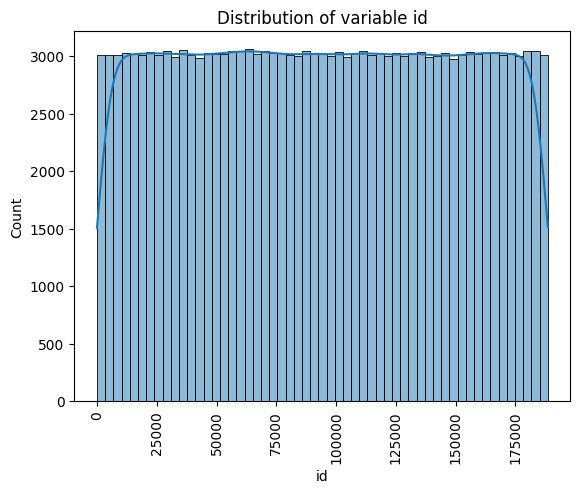

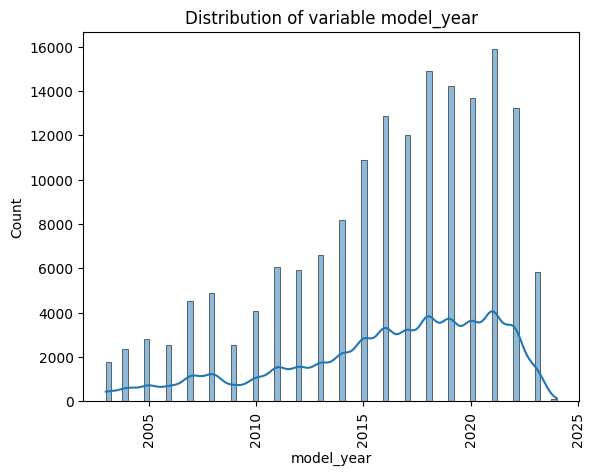

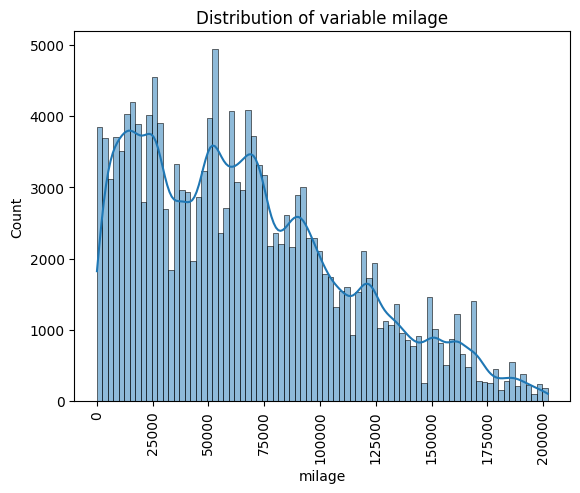

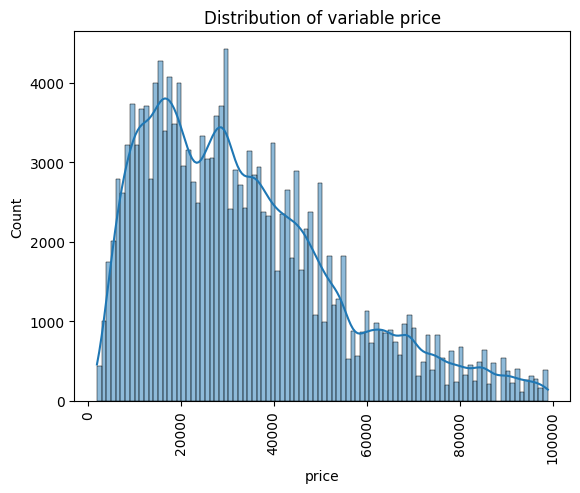

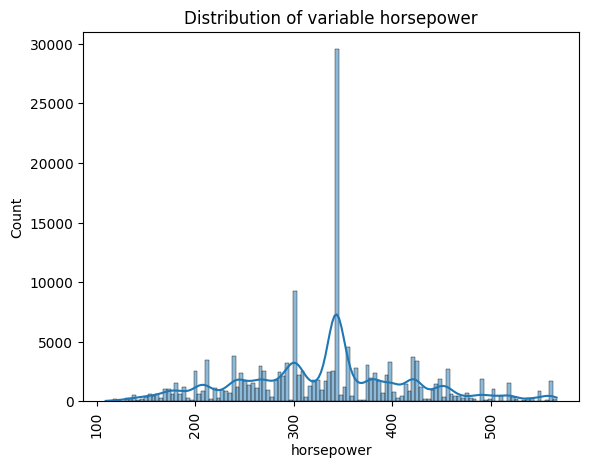

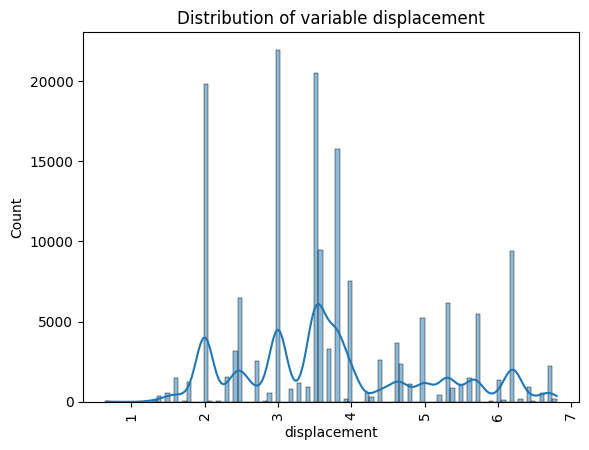

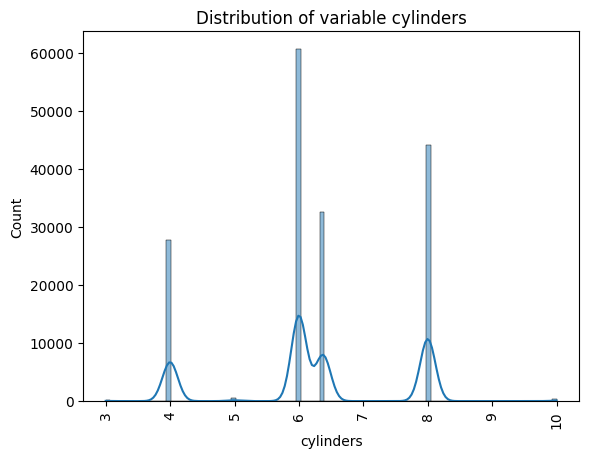

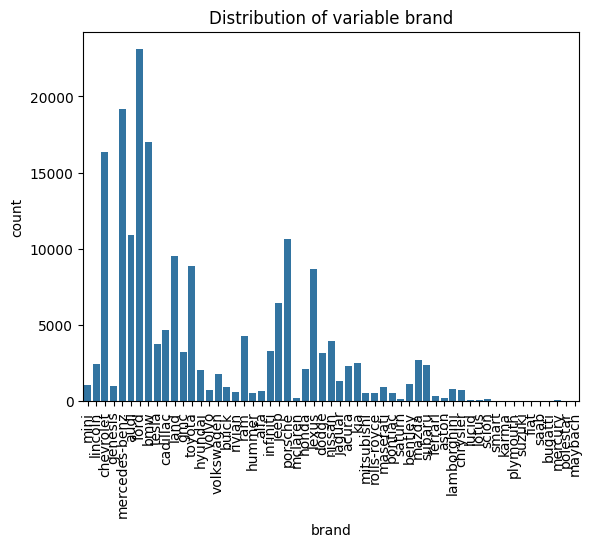

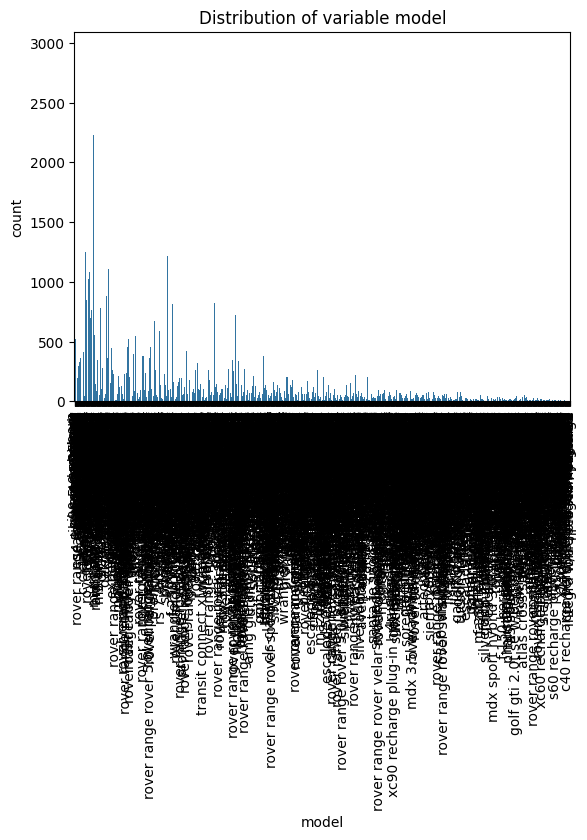

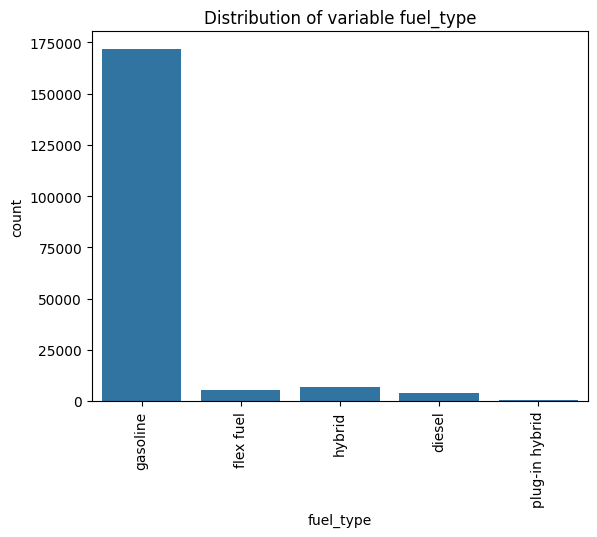

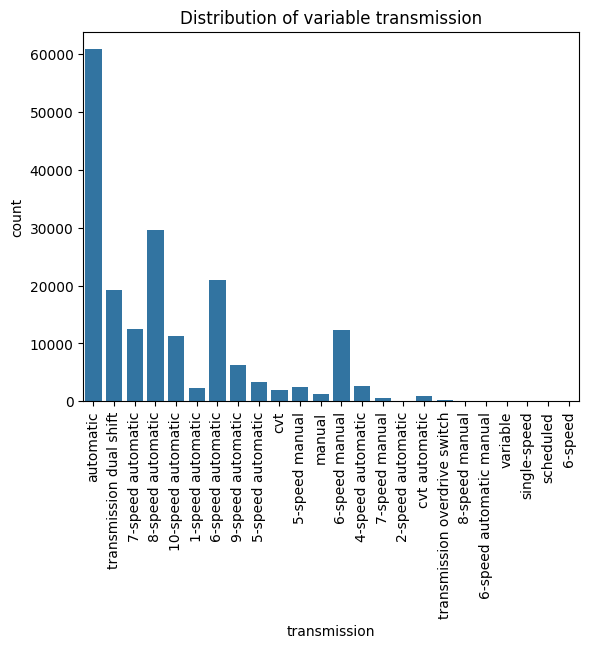

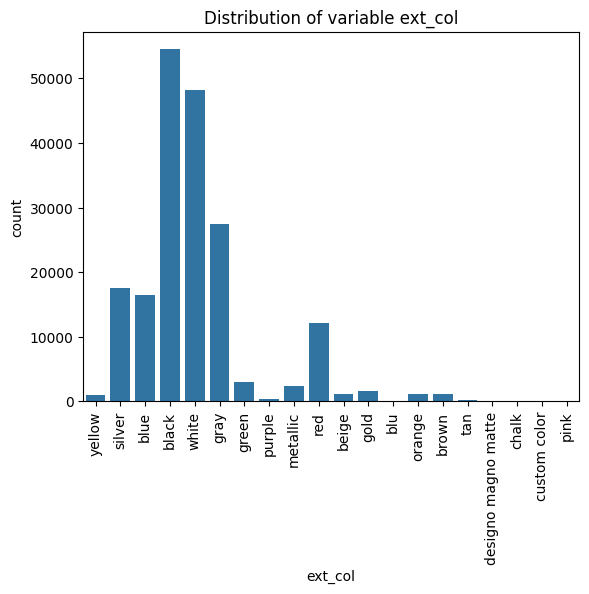

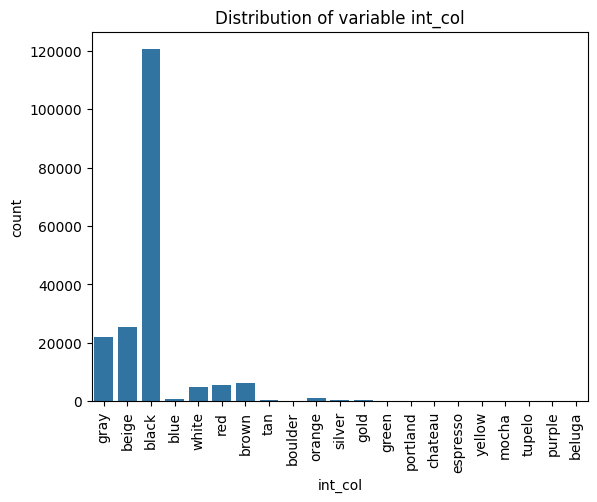

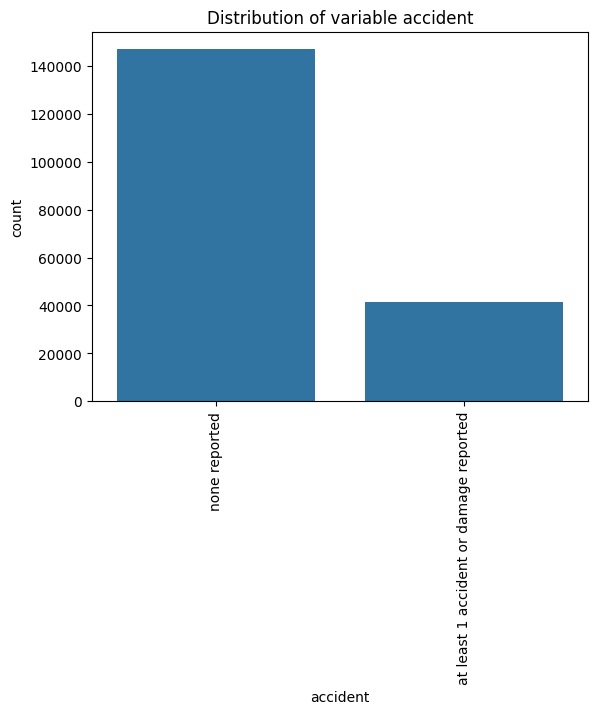

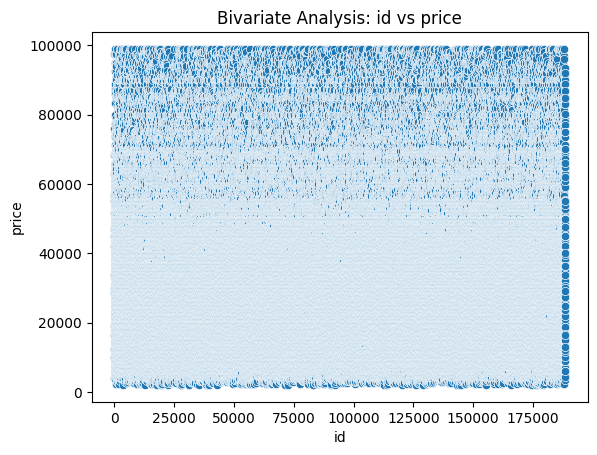

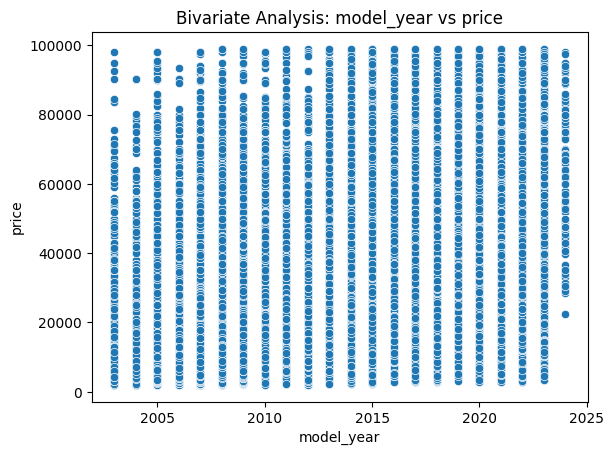

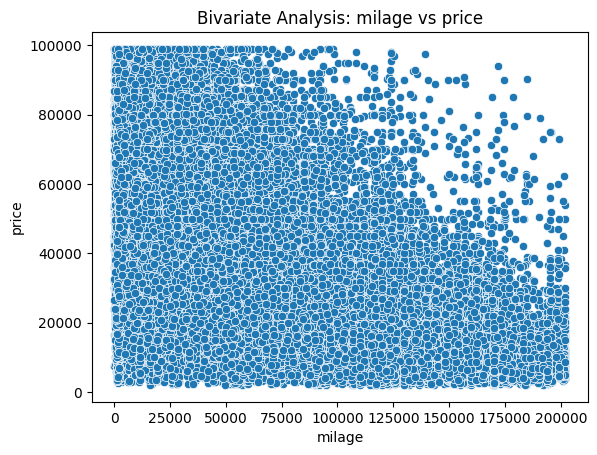

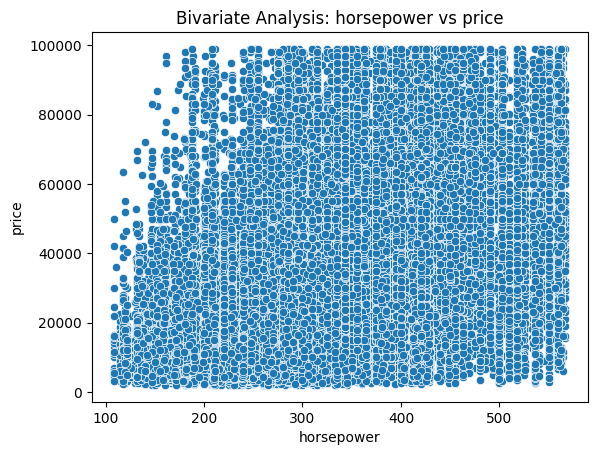

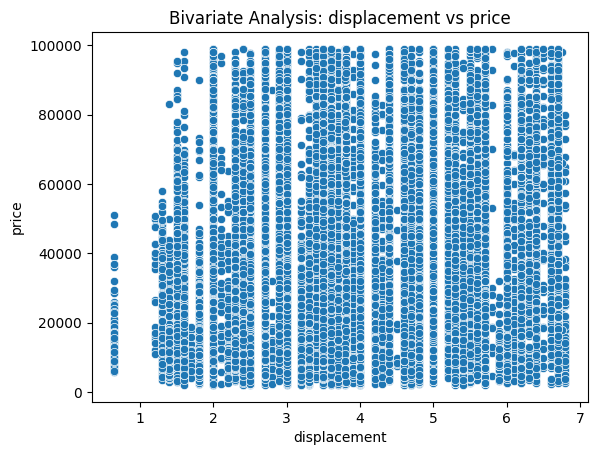

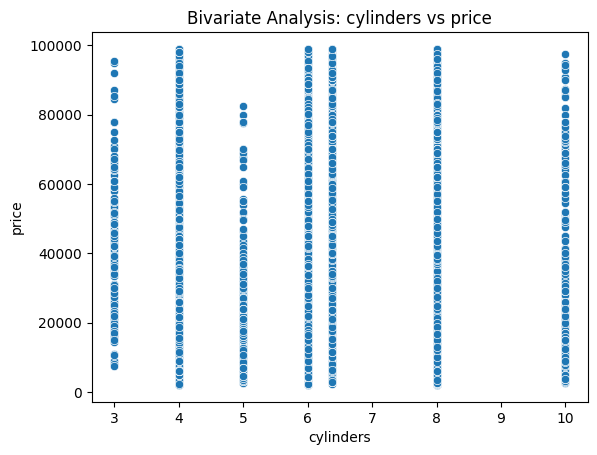

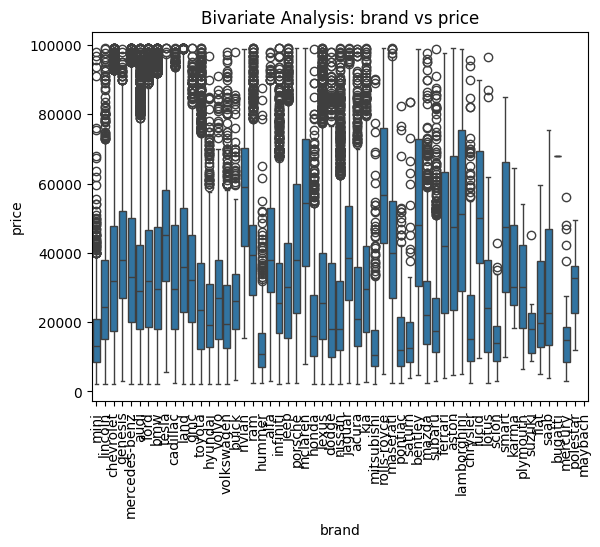

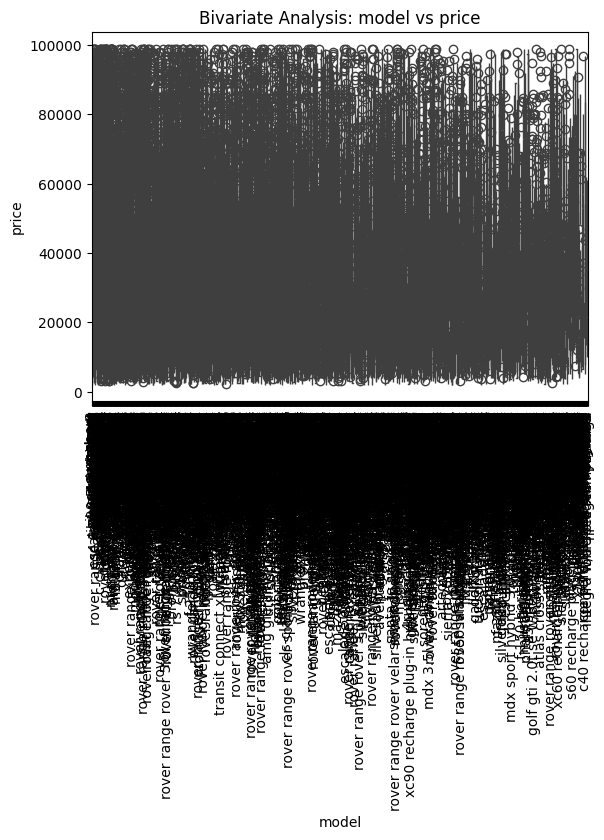

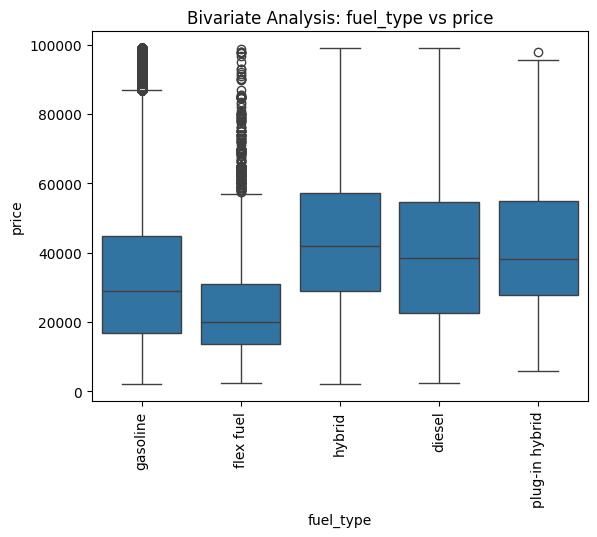

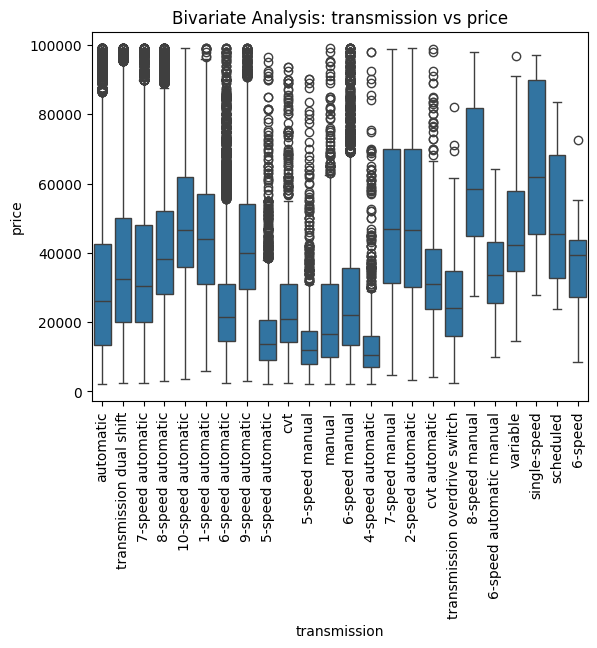

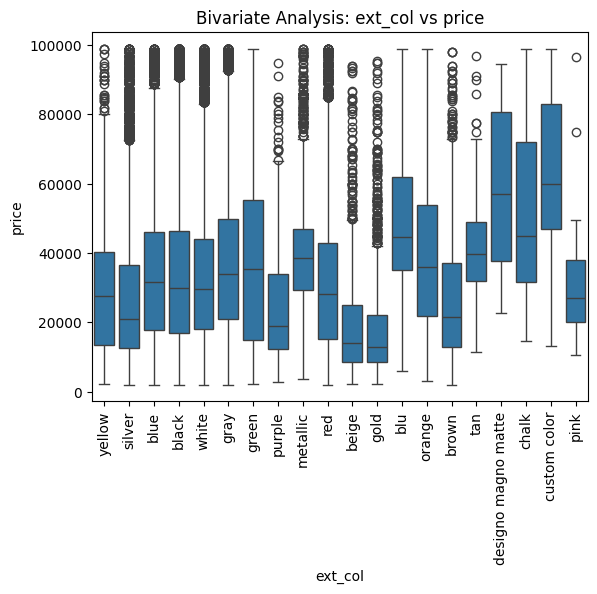

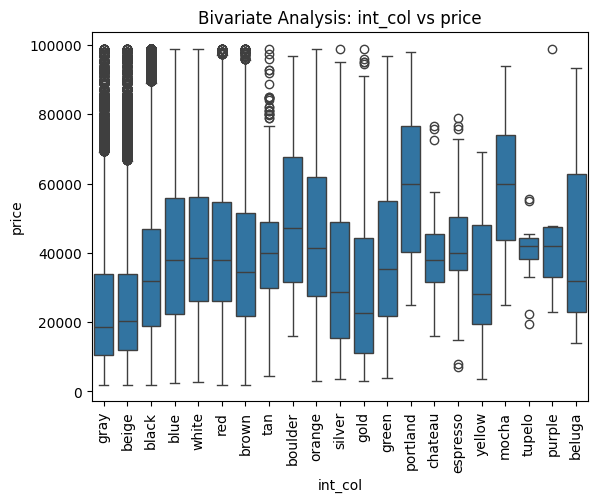

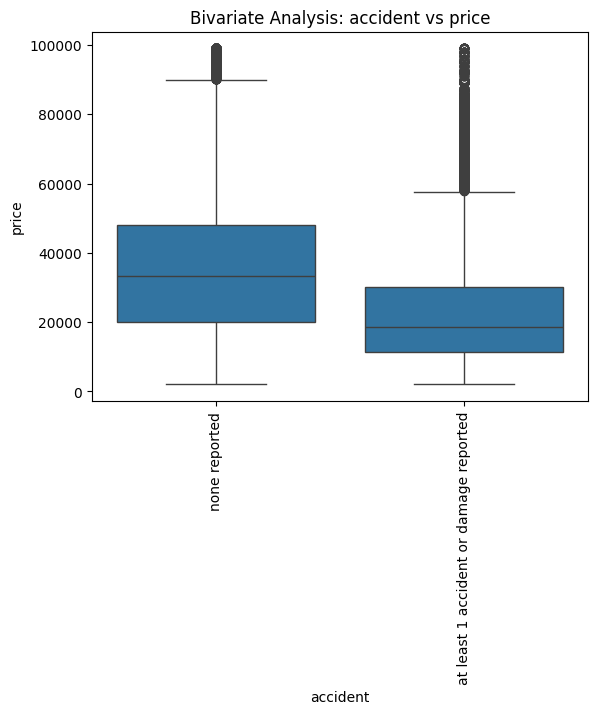

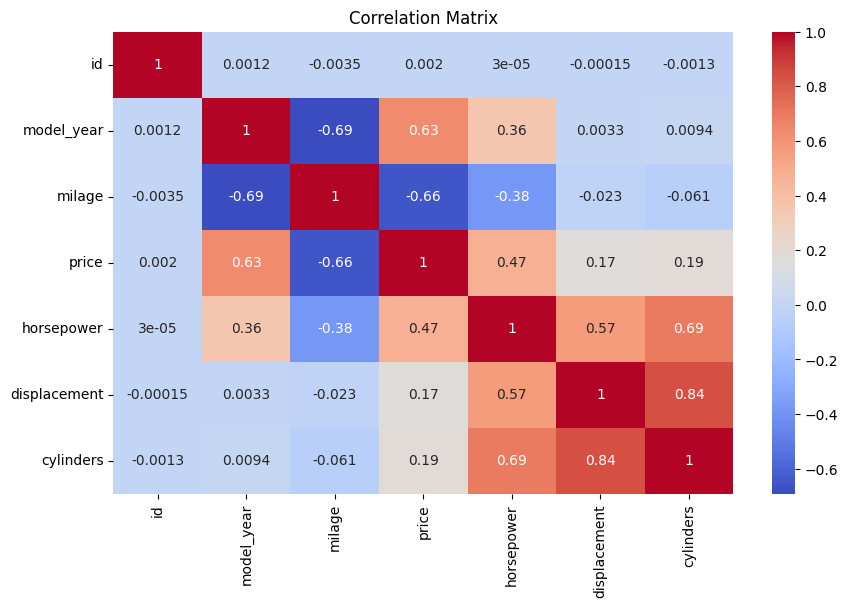

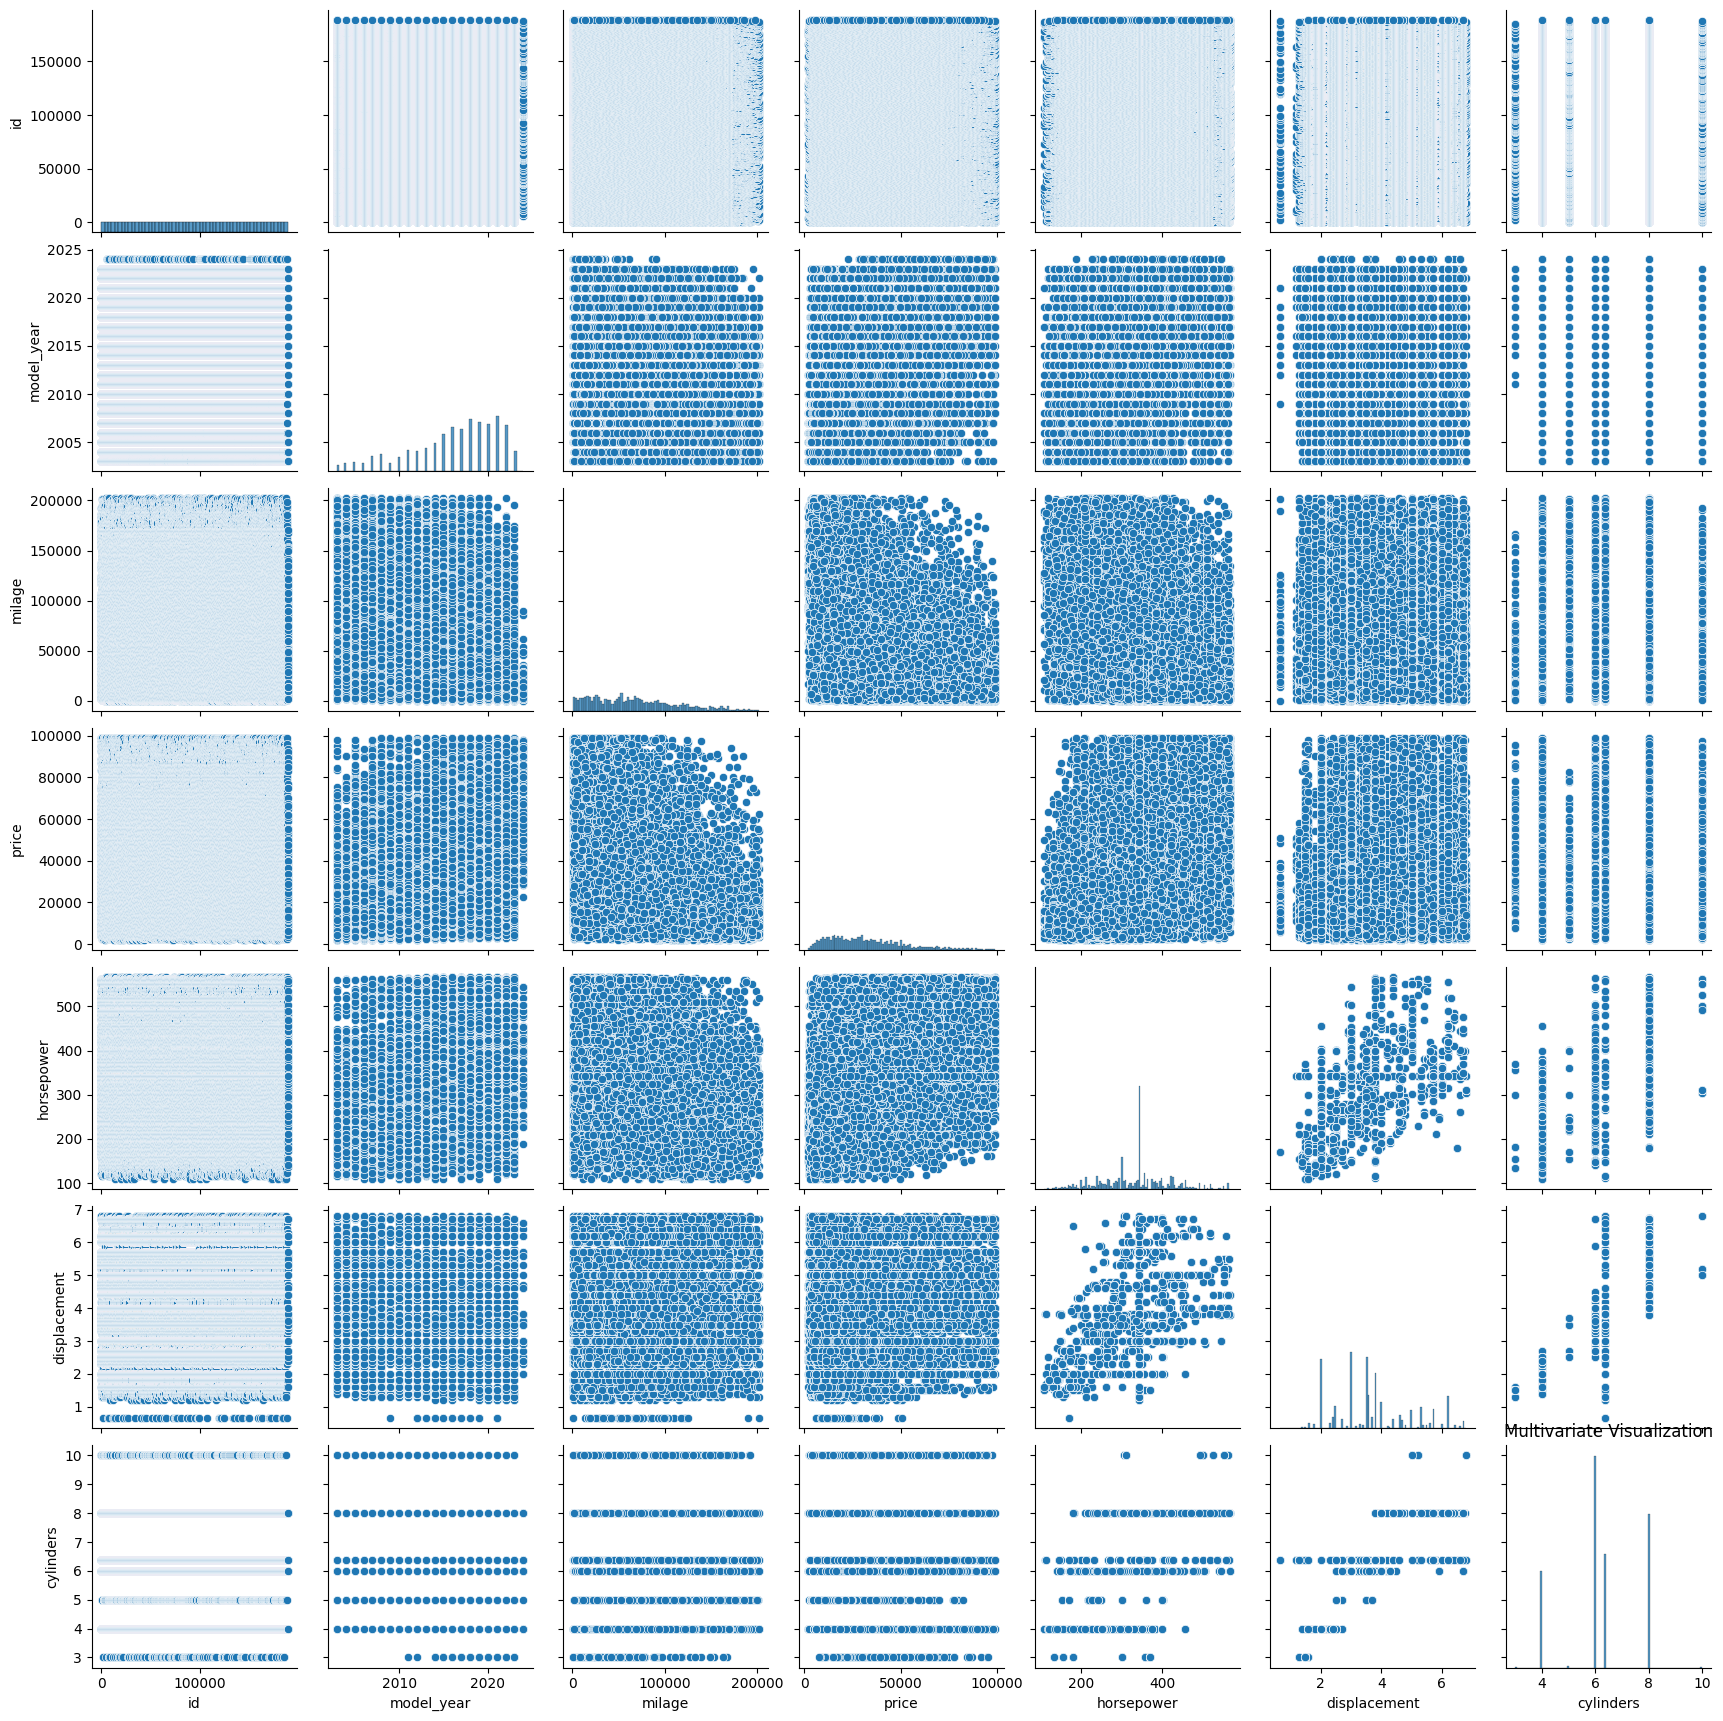

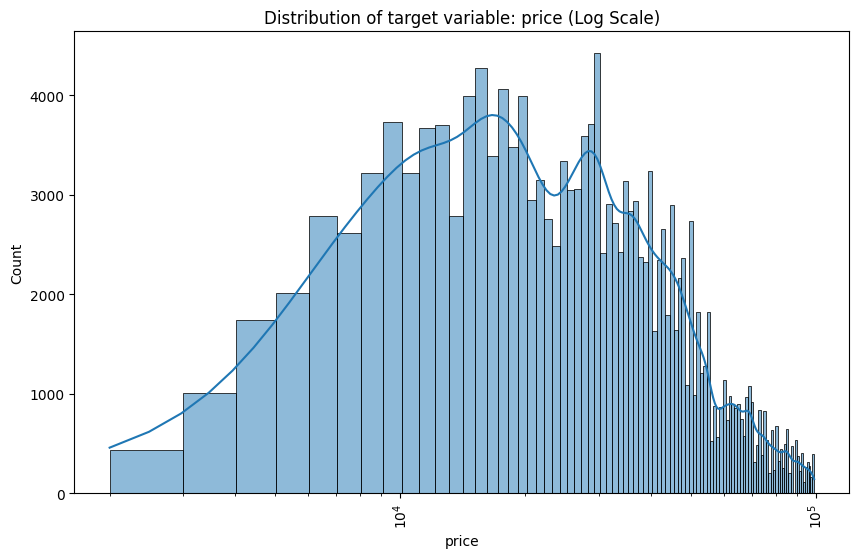

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


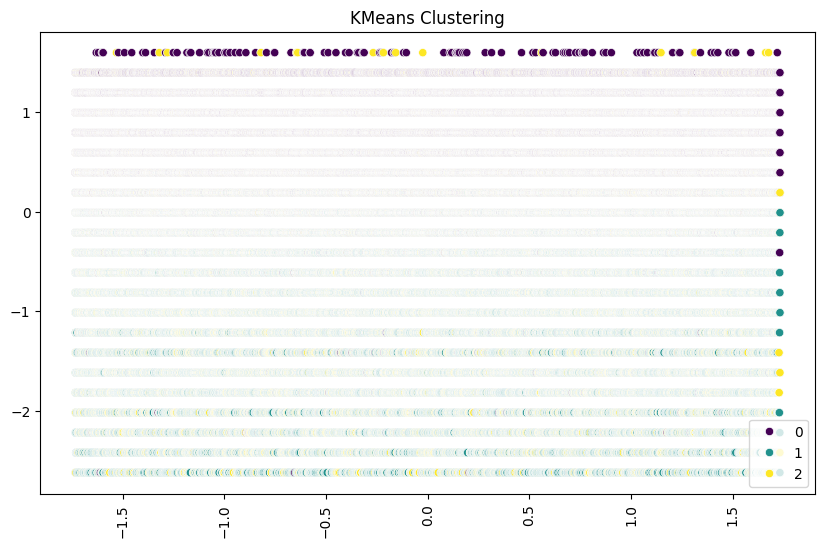

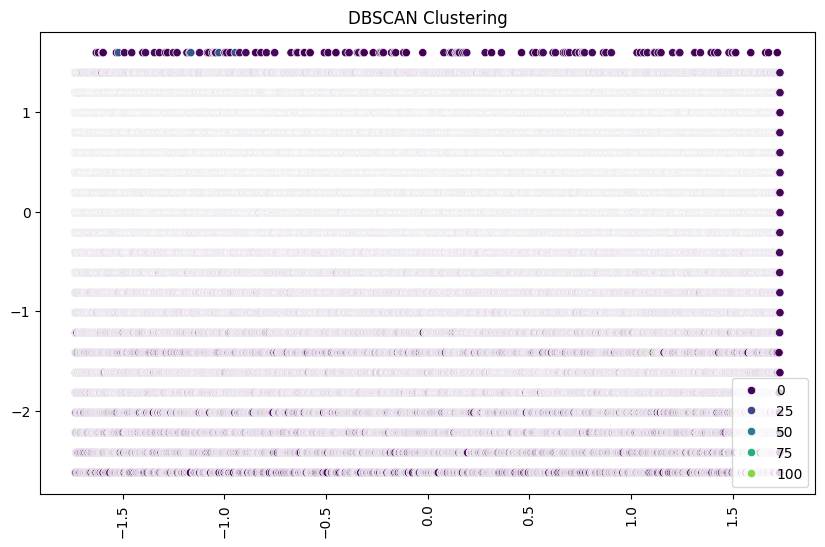

In [ ]:
target_column = 'price'

# Eseguiamo la classe EDA
eda = EDA(train_clean_1)

# Riassunto delle caratteristiche del dataset
eda.feature_summary()

# Statistiche descrittive
eda.descriptive_statistics()

# Valori mancanti
eda.missing_values()

# Gestione dei valori mancanti (riempi con la media)
# eda.handle_missing_values(strategy='mean')

# Rimozione dei duplicati
eda.remove_duplicates()

# Analisi degli outlier
eda.outlier_analysis()

# Rimozione degli outlier
eda.remove_outliers()

# Distribuzione univariata delle variabili numeriche
eda.univariate_distribution_numeric()

# Distribuzione univariata delle variabili categoriche
eda.univariate_distribution_categorical()

# Bivariate analysis between numeric variables and target column 'A'
eda.bivariate_analysis_numeric(target_column=target_column)

# Analisi bivariata tra variabili categoriche e la colonna target 'A'
eda.bivariate_analysis_categorical(target_column=target_column)

# Matrice di correlazione
eda.correlation_matrix()

# Analisi PCA
eda.pca_analysis(n_components=2)

# Predictive Power Score (PPS)
eda.predict_score_index(target_column=target_column)

# Visualizzazione multivariata
eda.multivariate_visualization()

# Valutazione della normalità
eda.normality_assessment()

# Analisi della distribuzione della variabile target 'A' con scala logaritmica
eda.target_distribution_analysis(target_column=target_column, log_scale=True)

# Analisi di clustering con KMeans e DBSCAN
eda.clustering_analysis(n_clusters=3)

# Salva il dataframe finale con le colonne di clustering in un file CSV
eda.save_final_db('final_dataframe.csv')

In [ ]:
train_clean_2 = pd.read_csv('final_dataframe.csv')
test_clean_2 = test_clean_1.copy(deep = True)

In [ ]:
test_clean_2.shape, train_clean_2.shape, test_clean_1.shape, train_clean_1.shape

((125690, 13), (166048, 16), (125690, 13), (188533, 14))

In [ ]:
train_clean_1.columns

Index(['id', 'brand', 'model', 'model_year', 'milage', 'fuel_type',
       'transmission', 'ext_col', 'int_col', 'accident', 'price', 'horsepower',
       'displacement', 'cylinders'],
      dtype='object')

In [ ]:
train_clean_2.columns

Index(['id', 'brand', 'model', 'model_year', 'milage', 'fuel_type',
       'transmission', 'ext_col', 'int_col', 'accident', 'price', 'horsepower',
       'displacement', 'cylinders', 'KMeans_Cluster', 'DBSCAN_Cluster'],
      dtype='object')

### Featurengineer

In [ ]:
train_fe = train_clean_2.copy(deep = True)
test_fe = test_clean_2.copy(deep = True)

train_fe.shape, test_fe.shape

((166048, 16), (125690, 13))

In [ ]:
train_fe.head()

id          brand               model  model_year  milage  fuel_type  \
0   3        genesis    g90 5.0 ultimate        2017   19500   gasoline   
1   4  mercedes-benz         metris base        2021    7388   gasoline   
2   5           audi       a6 2.0t sport        2018   40950   gasoline   
3   6           audi           a8 l 3.0t        2016   62200   gasoline   
4   7      chevrolet  silverado 1500 1lz        2016  102604  flex fuel   

              transmission ext_col int_col       accident  price  horsepower  \
0  transmission dual shift   black   black  none reported  45000       420.0   
1        7-speed automatic   black   beige  none reported  97500       208.0   
2                automatic   white   black  none reported  29950       252.0   
3        8-speed automatic   black   black  none reported  28500       333.0   
4                automatic   white    gray  none reported  12500       355.0   

   displacement  cylinders  KMeans_Cluster  DBSCAN_Cluster  
0           5.0        8.0               2               0  
1           2.0        4.0               0               8  
2           2.0        4.0               1               1  
3           3.0        6.0               0               2  
4           5.3        8.0               2               0

#### Extract "brand" fetures
* Luxury
* Discontinued
* Parent
* Region

In [ ]:
def transform_brand_column(df, brand_column):
    # Convert all values in the brand column to lowercase
    df[brand_column] = df[brand_column].str.lower()

    # Define the mapping for luxury brands (in lowercase)
    luxury_brands = [
        'mercedes-benz', 'audi', 'bmw', 'lexus', 'porsche', 'maserati',
        'ferrari', 'aston', 'rolls-royce', 'bentley', 'lamborghini',
        'jaguar', 'mclaren', 'lucid', 'karma', 'bugatti', 'maybach'
    ]

    # Define the mapping for discontinued brands (in lowercase)
    discontinued_brands = [
        'pontiac', 'saturn', 'hummer', 'plymouth', 'mercury',
        'saab', 'scion', 'suzuki', 'fiat'
    ]

    # Define the mapping for parent companies (in lowercase)
    parent_group = {
        'chevrolet': 'general motors', 'buick': 'general motors',
        'gmc': 'general motors', 'cadillac': 'general motors',
        'jeep': 'stellantis', 'dodge': 'stellantis',
        'chrysler': 'stellantis', 'ram': 'stellantis',
        'audi': 'volkswagen', 'porsche': 'volkswagen',
        'lamborghini': 'volkswagen', 'bentley': 'volkswagen',
        # Add more mappings as needed
    }

    # Define the mapping for regions (in lowercase)
    region_mapping = {
        'bmw': 'europe', 'mercedes-benz': 'europe', 'audi': 'europe',
        'porsche': 'europe', 'volkswagen': 'europe', 'volvo': 'europe',
        'chevrolet': 'america', 'ford': 'america', 'cadillac': 'america',
        'tesla': 'america', 'gmc': 'america', 'chrysler': 'america',
        'toyota': 'asia', 'honda': 'asia', 'hyundai': 'asia',
        'nissan': 'asia', 'kia': 'asia', 'lexus': 'asia',
        # Add more mappings as needed
    }

    # Define the mapping for electric/alternative fuel brands (in lowercase)
    electric_brands = ['tesla', 'rivian', 'polestar', 'lucid', 'karma']

    # Apply transformations
    df['is_luxury'] = df[brand_column].apply(lambda x: 1 if x in luxury_brands else 0)
    df['is_discontinued'] = df[brand_column].apply(lambda x: 1 if x in discontinued_brands else 0)
    df['parent_group'] = df[brand_column].map(parent_group).fillna('independent')
    df['region'] = df[brand_column].map(region_mapping).fillna(np.nan)
    df['is_electric'] = df[brand_column].apply(lambda x: 1 if x in electric_brands else 0)

    print(f"Brand column '{brand_column}' transformed successfully.")
    print(f"New columns created: is_luxury, is_discontinued, parent_group, region, is_electric")

    return df

In [ ]:
train_fe = transform_brand_column(train_fe, 'brand')
test_fe = transform_brand_column(test_fe, 'brand')

Brand column 'brand' transformed successfully.
New columns created: is_luxury, is_discontinued, parent_group, region, is_electric
Brand column 'brand' transformed successfully.
New columns created: is_luxury, is_discontinued, parent_group, region, is_electric


In [ ]:
missing_values(train_fe)

Valori mancanti per colonna:
         Count  Percentage
region  41453   24.964468


In [ ]:
train_fe = handle_missing_values(train_fe,'region', strategy='mode')
test_fe = handle_missing_values(test_fe,'region', strategy='mode')

Missing values in column 'region' handled using the strategy: mode
No missing values remain in column 'region'.
Missing values in column 'region' handled using the strategy: mode
No missing values remain in column 'region'.


#### Adding other features

* Car Age: Adds a car_age feature based on model_year.
* Mileage Buckets: Segments mileage into buckets (milage_bucket).
* Power-to-Displacement Ratio: Adds a power_to_displacement ratio.
* Transmission Type: Simplifies transmission into "automatic" or "manual" (transmission_type).
* Simplified Colors: Standardizes ext_col and int_col into basic colors (ext_col_simplified, int_col_simplified).
* Mileage-to-Age Ratio: Adds a feature for vehicle wear (milage_age_ratio).

In [ ]:
def feature_engineering(df):
    # 1. Car Age
    df['car_age'] = 2024 - df['model_year']
    df['car_age_bucket'] = pd.cut(df['car_age'], bins=[-np.inf, 5, 10, np.inf], labels=['new', 'medium', 'old'])

    # 2. Mileage Buckets
    df['milage_bucket'] = pd.cut(df['milage'], bins=[0, 20000, 60000, 100000, np.inf], labels=['low', 'medium', 'high', 'very high'])

    # 3. Power to Displacement Ratio
    df['power_to_displacement'] = df['horsepower'] / df['displacement']

    # 5. Transmission Type Simplification
    df['transmission_type'] = df['transmission'].apply(lambda x: 'automatic' if 'automatic' in x.lower() else 'manual')

    # 6. Accident Binary
    df['accident_binary'] = df['accident'].apply(lambda x: 1 if x != 'none reported' else 0)

    # 9. Simplified Exterior and Interior Color
    basic_colors = ['black', 'white', 'gray', 'red', 'blue', 'green', 'silver']

    def simplify_color(color):
        color = color.lower()
        for basic_color in basic_colors:
            if basic_color in color:
                return basic_color
        return 'other'

    df['ext_col_simplified'] = df['ext_col'].apply(simplify_color)
    df['int_col_simplified'] = df['int_col'].apply(simplify_color)

    # 10. Mileage to Age Ratio
    df['milage_age_ratio'] = df.apply(lambda row: row['milage'] / row['car_age'] if row['car_age'] > 0 else np.nan, axis=1)

    # 11. Cylinder Buckets
    df['cylinder_bucket'] = pd.cut(df['cylinders'], bins=[-np.inf, 5, 7, np.inf], labels=['low', 'med', 'big'])

    print("Feature engineering completed.")
    print("New features created: car_age, milage_bucket, power_to_displacement, price_category, transmission_type, accident_binary, ext_col_simplified, int_col_simplified, milage_age_ratio")

    # Return the dataframe with new features
    return df


In [ ]:
train_fe = feature_engineering(train_fe)
test_fe = feature_engineering(test_fe)

Feature engineering completed.
New features created: car_age, milage_bucket, power_to_displacement, price_category, transmission_type, accident_binary, ext_col_simplified, int_col_simplified, milage_age_ratio
Feature engineering completed.
New features created: car_age, milage_bucket, power_to_displacement, price_category, transmission_type, accident_binary, ext_col_simplified, int_col_simplified, milage_age_ratio


In [ ]:
missing_values(train_fe)

Valori mancanti per colonna:
                   Count  Percentage
milage_age_ratio    133    0.080097


In [ ]:
train_fe = handle_missing_values(train_fe,'milage_age_ratio', strategy='knn')
test_fe = handle_missing_values(test_fe,'milage_age_ratio', strategy='knn')

Missing values in column 'milage_age_ratio' handled using the strategy: knn
No missing values remain in column 'milage_age_ratio'.
Missing values in column 'milage_age_ratio' handled using the strategy: knn
No missing values remain in column 'milage_age_ratio'.


In [ ]:
train_fe.head()

id          brand               model  model_year  milage  fuel_type  \
0   3        genesis    g90 5.0 ultimate        2017   19500   gasoline   
1   4  mercedes-benz         metris base        2021    7388   gasoline   
2   5           audi       a6 2.0t sport        2018   40950   gasoline   
3   6           audi           a8 l 3.0t        2016   62200   gasoline   
4   7      chevrolet  silverado 1500 1lz        2016  102604  flex fuel   

              transmission ext_col int_col       accident  ...  car_age  \
0  transmission dual shift   black   black  none reported  ...        7   
1        7-speed automatic   black   beige  none reported  ...        3   
2                automatic   white   black  none reported  ...        6   
3        8-speed automatic   black   black  none reported  ...        8   
4                automatic   white    gray  none reported  ...        8   

   car_age_bucket  milage_bucket  power_to_displacement  transmission_type  \
0          medium            low              84.000000             manual   
1             new            low             104.000000          automatic   
2          medium         medium             126.000000          automatic   
3          medium           high             111.000000          automatic   
4          medium      very high              66.981132          automatic   

   accident_binary  ext_col_simplified  int_col_simplified milage_age_ratio  \
0                0               black               black      2785.714286   
1                0               black               other      2462.666667   
2                0               white               black      6825.000000   
3                0               black               black      7775.000000   
4                0               white                gray     12825.500000   

  cylinder_bucket  
0             big  
1             low  
2             low  
3             med  
4             big  

[5 rows x 31 columns]

#### Save/Load data

In [ ]:
train_clean_2.shape, test_clean_2.shape, train_fe.shape, test_fe.shape

((166048, 16), (125690, 13), (166048, 31), (125690, 28))

In [ ]:
train_fe = pd.read_pickle('train_fe.pkl')
test_fe = pd.read_pickle('test_fe.pkl')

In [ ]:
train_fe.shape, test_fe.shape

((166048, 31), (125690, 28))

In [ ]:
train_fe.shape, test_fe.shape

((166048, 31), (125690, 28))

### Feature select

In [ ]:
test_fe_2 = test_fe.copy(deep = True)
train_fe_2 = train_fe.copy(deep = True)

#### Correlation Analysis

In [ ]:
def remove_highly_correlated_features(dataframe, threshold=0.8):
    """
    Removes features from a DataFrame that have a correlation greater than the specified threshold.

    Parameters:
    df (pd.DataFrame): DataFrame containing the features.
    threshold (float): The correlation threshold above which features will be removed. Default is 0.8.

    Returns:
    pd.DataFrame: DataFrame with highly correlated features removed.
    list: List of features that were removed.
    """
    # Select numeric only
    df = dataframe[['model_year', 'milage', 'horsepower', 'displacement', 'cylinders', 'car_age', 'power_to_displacement', 'milage_age_ratio']]

    # Calculate the correlation matrix
    corr_matrix = df.corr()

    # Select the upper triangle of the correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

    # Find features with correlation greater than the threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    # Print features that are being removed
    print(f"Features removed due to high correlation (threshold = {threshold}): {to_drop}")

    # Drop the features from the DataFrame
    dataframe = dataframe.drop(columns=to_drop)

    return dataframe

In [ ]:
train_fe_2 = remove_highly_correlated_features(train_fe_2, threshold=0.8)
test_fe_2 = remove_highly_correlated_features(test_fe_2, threshold=0.8)

Features removed due to high correlation (threshold = 0.8): ['cylinders']
Features removed due to high correlation (threshold = 0.8): ['cylinders']


#### Chi-Square Categorical

In [ ]:
import pandas as pd
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder

def feature_selection_with_chi2(df, target, p_value_threshold=0.05):
    # Identify categorical columns
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    dropped_columns = []

    for col in categorical_columns:
        # Encode categorical columns
        le = LabelEncoder()
        df[col + '_encoded'] = le.fit_transform(df[col])

        # Calculate chi-squared test between encoded column and the target
        chi2_val, p_val = chi2(df[[col + '_encoded']], df[target])

        # If p-value is greater than threshold, drop the feature
        if p_val > p_value_threshold:
            df.drop(columns=[col], inplace=True)
            dropped_columns.append(col)

    # Optionally drop the encoded versions as well
    df.drop(columns=[col + '_encoded' for col in categorical_columns], inplace=True)

    # Print removed columns
    print(f"Removed categorical columns due to high p-value: {dropped_columns}")

    return df


In [ ]:
train_fe_2 = feature_selection_with_chi2(train_fe, target='price')
test_fe_2 = feature_selection_with_chi2(train_fe, target='price')

Removed categorical columns due to high p-value: []
Removed categorical columns due to high p-value: []


#### Random forest regressor

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd

def select_top_features(df, target_col, n_features=10):
    # Separate features and target
    x_train = df.drop(columns=[target_col])
    y_train = df[target_col]

    # Identify categorical and numeric columns
    categorical_cols = x_train.select_dtypes(include=['object', 'category']).columns.tolist()
    numeric_cols = x_train.select_dtypes(include=['number']).columns.tolist()

    # Create a ColumnTransformer to apply OneHotEncoder to categorical columns
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', numeric_cols),  # Keep numeric columns unchanged
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  # Encode categorical columns
        ]
    )

    # Create a pipeline with preprocessing and model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(random_state=42))
    ])

    # Fit the model
    pipeline.fit(x_train, y_train)

    # Get feature importances from the model
    feature_importances = pipeline.named_steps['model'].feature_importances_

    # Create a Series for feature importances
    all_feature_names = (numeric_cols + list(pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_cols)))
    feature_importances_series = pd.Series(feature_importances, index=all_feature_names)

    # Select top n features
    selected_features = feature_importances_series.nlargest(n_features).index.tolist()

    # Print removed features
    removed_features = set(all_feature_names) - set(selected_features)
    print("Removed features:", removed_features)

    return selected_features


In [ ]:
selected_features = select_top_features(train_fe, target_col='price', n_features=10)

KeyboardInterrupt: 

### Encode & Normalize

In [ ]:
test_en = test_fe.copy(deep = True)
train_en = train_fe.copy(deep = True)

In [ ]:
train_en.head(1)

id    brand             model  model_year  milage fuel_type  \
0   3  genesis  g90 5.0 ultimate        2017   19500  gasoline   

              transmission ext_col int_col       accident  ...  car_age  \
0  transmission dual shift   black   black  none reported  ...        7   

   car_age_bucket  milage_bucket  power_to_displacement  transmission_type  \
0          medium            low                   84.0             manual   

   accident_binary ext_col_simplified int_col_simplified  milage_age_ratio  \
0                0              black              black       2785.714286   

   cylinder_bucket  
0              big  

[1 rows x 29 columns]

In [ ]:
drop_columns(train_en,'KMeans_Cluster')
# drop_columns(test_en,'KMeans_Cluster')

drop_columns(train_en,'DBSCAN_Cluster')
# drop_columns(test_en,'DBSCAN_Cluster')

Colonne rimosse: KMeans_Cluster
Colonne rimosse: DBSCAN_Cluster


In [ ]:
drop_columns(train_en,'KMeans_Cluster')
# drop_columns(test_en,'KMeans_Cluster')

drop_columns(train_en,'DBSCAN_Cluster')
# drop_columns(test_en,'DBSCAN_Cluster')

drop_columns(test_en,'model')
drop_columns(train_en,'model')

drop_columns(test_en,'ext_col')
drop_columns(train_en,'ext_col')

drop_columns(test_en,'int_col')
drop_columns(train_en,'int_col')

drop_columns(test_en,'brand')
drop_columns(train_en,'brand')

drop_columns(test_en,'cylinders')
drop_columns(train_en,'cylinders')

drop_columns(test_en,'model_year')
drop_columns(train_en,'model_year')

drop_columns(test_en,'accident')
drop_columns(train_en,'accident')

drop_columns(test_en,'car_age_bucket')
drop_columns(train_en,'car_age_bucket')

drop_columns(test_en,'milage_bucket')
drop_columns(train_en,'milage_bucket')

drop_columns(test_en,'transmission')
drop_columns(train_en,'transmission')


NameError: name 'drop_columns' is not defined

In [ ]:
train_en.columns

Index(['id', 'milage', 'fuel_type', 'price', 'horsepower', 'displacement',
       'is_luxury', 'is_discontinued', 'parent_group', 'region', 'is_electric',
       'car_age', 'power_to_displacement', 'transmission_type',
       'accident_binary', 'ext_col_simplified', 'int_col_simplified',
       'milage_age_ratio', 'cylinder_bucket'],
      dtype='object')

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler

def frequency_encode(df, columns):
    df_encoded = df.copy()  # Create a copy to avoid modifying the original DataFrame
    for column in columns:
        # Calculate the frequency of each category
        freq = df_encoded[column].value_counts()
        # Map the frequencies back to the original column
        df_encoded[column + '_encoded'] = df_encoded[column].map(freq)

    df_encoded.drop(columns, axis=1, inplace=True)

    print(f'following columns have been encoded {columns}')
    return df_encoded

def encode_categorical_columns(df):
    df_encoded = df.copy(deep = True)
    encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

    # Select categorical columns
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns

    for col in categorical_columns:
        # Convert the column to string to handle mixed data types
        df_encoded[col] = df_encoded[col].astype(str)

        # One-Hot Encoding without unknown values
        encoded_cols = pd.DataFrame(encoder.fit_transform(df[[col]]), columns=encoder.get_feature_names_out([col]))

        # Concatenate the encoded columns and drop the original categorical column
        df_encoded = pd.concat([df_encoded.reset_index(drop=True), encoded_cols.reset_index(drop=True)], axis=1)
        df_encoded.drop(col, axis=1, inplace=True)

    print(f'following columns have been encoded {categorical_columns}')

    return df_encoded

def normalize_continuous_columns(df, continuous_columns, batch_size=1000):
    scaler = StandardScaler()

    # Number of rows in the DataFrame
    n_rows = df.shape[0]

    # Normalize in batches
    for start in range(0, n_rows, batch_size):
        # Define the end index for the current batch
        end = min(start + batch_size, n_rows)
        # Get the current batch of continuous columns
        batch = df.loc[start:end-1, continuous_columns]
        # Normalize the current batch
        normalized_batch = scaler.fit_transform(batch)
        # Update the corresponding rows in the normalized DataFrame
        df.loc[start:end-1, continuous_columns] = normalized_batch

    return df


In [ ]:
# train_en = frequency_encode(train_en, ['transmission'])
# test_en = frequency_encode(test_en, ['transmission'])

In [ ]:
numeric_df = test_en.select_dtypes(include=np.number)
numeric_df.columns
numeric_df = numeric_df.drop(columns=['id'], errors='ignore')

# numeric_df = ['milage', 'horsepower', 'displacement','car_age', 'power_to_displacement','milage_age_ratio']

train_en = normalize_continuous_columns(train_en, numeric_df.columns)
test_en = normalize_continuous_columns(test_en, numeric_df.columns)

<ipython-input-9-cc8097bb31f8>:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.17116536  0.97570289  0.37229974 -0.02996902 -0.02996902  0.77456851
 -0.23110341 -0.23110341  0.17116536 -0.63337217  1.37797166  0.17116536
  0.97570289  0.97570289 -1.03564094  0.57343413  1.37797166 -0.02996902
 -0.83450655  0.37229974 -0.43223779 -0.63337217 -0.43223779  0.17116536
 -0.63337217  0.57343413  0.37229974 -1.4379097   0.57343413 -0.23110341
  0.77456851 -0.02996902  1.17683727 -2.644716    0.57343413 -0.43223779
  1.17683727 -1.84017847 -0.23110341 -2.24244723  0.77456851 -0.02996902
  0.77456851  0.97570289 -0.02996902 -0.02996902  1.17683727 -0.23110341
 -2.24244723 -1.63904408  0.17116536  0.17116536  1.17683727 -2.04131285
 -0.63337217 -0.02996902  0.57343413 -1.03564094 -0.63337217  1.37797166
  0.57343413  1.37797166  0.57343413  1.37797166 -0.43223779 -0.63337217
 -0.83450655 -1.4379097   0.37229

In [ ]:
train_en.head(5)

id          brand               model  model_year    milage  fuel_type  \
0   3        genesis    g90 5.0 ultimate    0.171165 -1.011606   gasoline   
1   4  mercedes-benz         metris base    0.975703 -1.273099   gasoline   
2   5           audi       a6 2.0t sport    0.372300 -0.548511   gasoline   
3   6           audi           a8 l 3.0t   -0.029969 -0.089733   gasoline   
4   7      chevrolet  silverado 1500 1lz   -0.029969  0.782570  flex fuel   

              transmission ext_col int_col       accident  ...   car_age  \
0  transmission dual shift   black   black  none reported  ... -0.171165   
1        7-speed automatic   black   beige  none reported  ... -0.975703   
2                automatic   white   black  none reported  ... -0.372300   
3        8-speed automatic   black   black  none reported  ...  0.029969   
4                automatic   white    gray  none reported  ...  0.029969   

   car_age_bucket  milage_bucket  power_to_displacement  transmission_type  \
0          medium            low              -0.392629             manual   
1             new            low               0.329918          automatic   
2          medium         medium               1.124719          automatic   
3          medium           high               0.582809          automatic   
4          medium      very high              -1.007476          automatic   

   accident_binary  ext_col_simplified  int_col_simplified milage_age_ratio  \
0        -0.551163               black               black        -1.131951   
1        -0.551163               black               other        -1.190606   
2        -0.551163               white               black        -0.398557   
3        -0.551163               black               black        -0.226070   
4        -0.551163               white                gray         0.690927   

  cylinder_bucket  
0             big  
1             low  
2             low  
3             med  
4             big  

[5 rows x 31 columns]

In [ ]:
test_en.shape, train_en.shape, numeric_df.shape

((125690, 18), (166048, 19), (125690, 10))

In [ ]:
train_en = encode_categorical_columns(train_en)
test_en = encode_categorical_columns(test_en)

following columns have been encoded Index(['fuel_type', 'parent_group', 'region', 'transmission_type',
       'ext_col_simplified', 'int_col_simplified', 'cylinder_bucket'],
      dtype='object')
following columns have been encoded Index(['fuel_type', 'parent_group', 'region', 'transmission_type',
       'ext_col_simplified', 'int_col_simplified', 'cylinder_bucket'],
      dtype='object')


In [ ]:
train_en.head()

id    milage  price  horsepower  displacement  is_luxury  is_discontinued  \
0   3 -1.011606  45000    1.008704      0.997008  -0.732187         -0.08396   
1   4 -1.273099  97500   -1.424347     -1.357821   1.365771         -0.08396   
2   5 -0.548511  29950   -0.919374     -1.357821   1.365771         -0.08396   
3   6 -0.089733  28500    0.010235     -0.572878   1.365771         -0.08396   
4   7  0.782570  12500    0.262722      1.232491  -0.732187         -0.08396   

   is_electric   car_age  power_to_displacement  ...  \
0     -0.14646 -0.171165              -0.392629  ...   
1     -0.14646 -0.975703               0.329918  ...   
2     -0.14646 -0.372300               1.124719  ...   
3     -0.14646  0.029969               0.582809  ...   
4     -0.14646  0.029969              -1.007476  ...   

   ext_col_simplified_white  int_col_simplified_blue  int_col_simplified_gray  \
0                       0.0                      0.0                      0.0   
1                       0.0                      0.0                      0.0   
2                       1.0                      0.0                      0.0   
3                       0.0                      0.0                      0.0   
4                       1.0                      0.0                      1.0   

   int_col_simplified_green  int_col_simplified_other  int_col_simplified_red  \
0                       0.0                       0.0                     0.0   
1                       0.0                       1.0                     0.0   
2                       0.0                       0.0                     0.0   
3                       0.0                       0.0                     0.0   
4                       0.0                       0.0                     0.0   

   int_col_simplified_silver  int_col_simplified_white  cylinder_bucket_low  \
0                        0.0                       0.0                  0.0   
1                        0.0                       0.0                  1.0   
2                        0.0                       0.0                  1.0   
3                        0.0                       0.0                  0.0   
4                        0.0                       0.0                  0.0   

   cylinder_bucket_med  
0                  0.0  
1                  0.0  
2                  0.0  
3                  1.0  
4                  0.0  

[5 rows x 38 columns]

In [ ]:
train_en.shape, test_en.shape

((166048, 38), (125690, 37))

### Encode & Normalize CAT

In [ ]:
test_en = test_fe.copy(deep = True)
train_en = train_fe.copy(deep = True)

In [ ]:
numeric_df = test_en.select_dtypes(include=np.number)
numeric_df.columns
numeric_df = numeric_df.drop(columns=['id'], errors='ignore')

In [ ]:
numeric_df.columns

Index(['model_year', 'milage', 'horsepower', 'displacement', 'cylinders',
       'is_luxury', 'is_discontinued', 'is_electric', 'car_age',
       'power_to_displacement', 'accident_binary', 'milage_age_ratio'],
      dtype='object')

In [ ]:


def normalize_continuous_columns(df, continuous_columns, batch_size=1000):
    scaler = StandardScaler()

    # Number of rows in the DataFrame
    n_rows = df.shape[0]

    # Normalize in batches
    for start in range(0, n_rows, batch_size):
        # Define the end index for the current batch
        end = min(start + batch_size, n_rows)
        # Get the current batch of continuous columns
        batch = df.loc[start:end-1, continuous_columns]
        # Normalize the current batch
        normalized_batch = scaler.fit_transform(batch)
        # Update the corresponding rows in the normalized DataFrame
        df.loc[start:end-1, continuous_columns] = normalized_batch

    return df

In [ ]:
train_en.columns

Index(['id', 'brand', 'model', 'model_year', 'milage', 'fuel_type',
       'transmission', 'ext_col', 'int_col', 'accident', 'price', 'horsepower',
       'displacement', 'cylinders', 'KMeans_Cluster', 'DBSCAN_Cluster',
       'is_luxury', 'is_discontinued', 'parent_group', 'region', 'is_electric',
       'car_age', 'car_age_bucket', 'milage_bucket', 'power_to_displacement',
       'transmission_type', 'accident_binary', 'ext_col_simplified',
       'int_col_simplified', 'milage_age_ratio', 'cylinder_bucket'],
      dtype='object')

In [ ]:
train_en = normalize_continuous_columns(train_en, numeric_df.columns)
test_en = normalize_continuous_columns(test_en, numeric_df.columns)

<ipython-input-113-dd37e28c96b1>:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.17116536  0.97570289  0.37229974 -0.02996902 -0.02996902  0.77456851
 -0.23110341 -0.23110341  0.17116536 -0.63337217  1.37797166  0.17116536
  0.97570289  0.97570289 -1.03564094  0.57343413  1.37797166 -0.02996902
 -0.83450655  0.37229974 -0.43223779 -0.63337217 -0.43223779  0.17116536
 -0.63337217  0.57343413  0.37229974 -1.4379097   0.57343413 -0.23110341
  0.77456851 -0.02996902  1.17683727 -2.644716    0.57343413 -0.43223779
  1.17683727 -1.84017847 -0.23110341 -2.24244723  0.77456851 -0.02996902
  0.77456851  0.97570289 -0.02996902 -0.02996902  1.17683727 -0.23110341
 -2.24244723 -1.63904408  0.17116536  0.17116536  1.17683727 -2.04131285
 -0.63337217 -0.02996902  0.57343413 -1.03564094 -0.63337217  1.37797166
  0.57343413  1.37797166  0.57343413  1.37797166 -0.43223779 -0.63337217
 -0.83450655 -1.4379097   0.372

In [ ]:
train_en.head()

id          brand               model  model_year    milage  fuel_type  \
0   3        genesis    g90 5.0 ultimate    0.171165 -1.011606   gasoline   
1   4  mercedes-benz         metris base    0.975703 -1.273099   gasoline   
2   5           audi       a6 2.0t sport    0.372300 -0.548511   gasoline   
3   6           audi           a8 l 3.0t   -0.029969 -0.089733   gasoline   
4   7      chevrolet  silverado 1500 1lz   -0.029969  0.782570  flex fuel   

              transmission ext_col int_col       accident  ...   car_age  \
0  transmission dual shift   black   black  none reported  ... -0.171165   
1        7-speed automatic   black   beige  none reported  ... -0.975703   
2                automatic   white   black  none reported  ... -0.372300   
3        8-speed automatic   black   black  none reported  ...  0.029969   
4                automatic   white    gray  none reported  ...  0.029969   

   car_age_bucket  milage_bucket  power_to_displacement  transmission_type  \
0          medium            low              -0.392629             manual   
1             new            low               0.329918          automatic   
2          medium         medium               1.124719          automatic   
3          medium           high               0.582809          automatic   
4          medium      very high              -1.007476          automatic   

   accident_binary  ext_col_simplified  int_col_simplified milage_age_ratio  \
0        -0.551163               black               black        -1.131951   
1        -0.551163               black               other        -1.190606   
2        -0.551163               white               black        -0.398557   
3        -0.551163               black               black        -0.226070   
4        -0.551163               white                gray         0.690927   

  cylinder_bucket  
0             big  
1             low  
2             low  
3             med  
4             big  

[5 rows x 31 columns]

In [ ]:
train_en.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166048 entries, 0 to 166047
Data columns (total 31 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   id                     166048 non-null  int64   
 1   brand                  166048 non-null  object  
 2   model                  166048 non-null  object  
 3   model_year             166048 non-null  float64 
 4   milage                 166048 non-null  float64 
 5   fuel_type              166048 non-null  object  
 6   transmission           166048 non-null  object  
 7   ext_col                166048 non-null  object  
 8   int_col                166048 non-null  object  
 9   accident               166048 non-null  object  
 10  price                  166048 non-null  int64   
 11  horsepower             166048 non-null  float64 
 12  displacement           166048 non-null  float64 
 13  cylinders              166048 non-null  float64 
 14  KMeans_Cluster      

In [ ]:
drop_columns(train_en,'KMeans_Cluster')
# drop_columns(test_en,'KMeans_Cluster')

drop_columns(train_en,'DBSCAN_Cluster')
# drop_columns(test_en,'DBSCAN_Cluster')

drop_columns(test_en,'model')
drop_columns(train_en,'model')

drop_columns(test_en,'ext_col')
drop_columns(train_en,'ext_col')

drop_columns(test_en,'int_col')
drop_columns(train_en,'int_col')

# drop_columns(test_en,'brand')
# drop_columns(train_en,'brand')

drop_columns(test_en,'cylinders')
drop_columns(train_en,'cylinders')

drop_columns(test_en,'model_year')
drop_columns(train_en,'model_year')

drop_columns(test_en,'accident')
drop_columns(train_en,'accident')

# drop_columns(test_en,'car_age_bucket')
# drop_columns(train_en,'car_age_bucket')

# drop_columns(test_en,'milage_bucket')
# drop_columns(train_en,'milage_bucket')

drop_columns(test_en,'cylinder_bucket')
drop_columns(train_en,'cylinder_bucket')

drop_columns(test_en,'transmission')
drop_columns(train_en,'transmission')

Colonne rimosse: KMeans_Cluster
Colonne rimosse: DBSCAN_Cluster
Colonne rimosse: model
Colonne rimosse: model
Colonne rimosse: ext_col
Colonne rimosse: ext_col
Colonne rimosse: int_col
Colonne rimosse: int_col
Colonne rimosse: cylinders
Colonne rimosse: cylinders
Colonne rimosse: model_year
Colonne rimosse: model_year
Colonne rimosse: accident
Colonne rimosse: accident
Colonne rimosse: cylinder_bucket
Colonne rimosse: cylinder_bucket
Colonne rimosse: transmission
Colonne rimosse: transmission


### Encode & Normalize Different features

In [ ]:
test_en = test_fe.copy(deep = True)
train_en = train_fe.copy(deep = True)

In [ ]:
train_en.head(1)

id    brand             model  model_year  milage fuel_type  \
0   3  genesis  g90 5.0 ultimate        2017   19500  gasoline   

              transmission ext_col int_col       accident  ...  car_age  \
0  transmission dual shift   black   black  none reported  ...        7   

   car_age_bucket  milage_bucket  power_to_displacement  transmission_type  \
0          medium            low                   84.0             manual   

   accident_binary  ext_col_simplified  int_col_simplified milage_age_ratio  \
0                0               black               black      2785.714286   

  cylinder_bucket  
0             big  

[1 rows x 31 columns]

In [ ]:
test_en.columns

Index(['id', 'brand', 'model', 'model_year', 'milage', 'fuel_type',
       'transmission', 'ext_col', 'int_col', 'accident', 'horsepower',
       'displacement', 'cylinders', 'is_luxury', 'is_discontinued',
       'parent_group', 'region', 'is_electric', 'car_age', 'car_age_bucket',
       'milage_bucket', 'power_to_displacement', 'transmission_type',
       'accident_binary', 'ext_col_simplified', 'int_col_simplified',
       'milage_age_ratio', 'cylinder_bucket'],
      dtype='object')

In [ ]:
drop_columns(train_en,'KMeans_Cluster')
# drop_columns(test_en,'KMeans_Cluster')

drop_columns(train_en,'DBSCAN_Cluster')
# drop_columns(test_en,'DBSCAN_Cluster')

Colonne rimosse: KMeans_Cluster
Colonne rimosse: DBSCAN_Cluster


In [ ]:
drop_columns(train_en,'KMeans_Cluster')
# drop_columns(test_en,'KMeans_Cluster')

drop_columns(train_en,'DBSCAN_Cluster')
# drop_columns(test_en,'DBSCAN_Cluster')

drop_columns(test_en,'model')
drop_columns(train_en,'model')

drop_columns(test_en,'ext_col')
drop_columns(train_en,'ext_col')

drop_columns(test_en,'int_col')
drop_columns(train_en,'int_col')

# drop_columns(test_en,'brand')
# drop_columns(train_en,'brand')

drop_columns(test_en,'cylinders')
drop_columns(train_en,'cylinders')

# drop_columns(test_en,'model_year')
# drop_columns(train_en,'model_year')

drop_columns(test_en,'model_year')
drop_columns(train_en,'model_year')

drop_columns(test_en,'accident')
drop_columns(train_en,'accident')

drop_columns(test_en,'car_age')
drop_columns(train_en,'car_age')

drop_columns(test_en,'milage_bucket')
drop_columns(train_en,'milage_bucket')

drop_columns(test_en,'transmission')
drop_columns(train_en,'transmission')


Colonne rimosse: KMeans_Cluster
Colonne rimosse: DBSCAN_Cluster
Colonne rimosse: model
Colonne rimosse: model
Colonne rimosse: ext_col
Colonne rimosse: ext_col
Colonne rimosse: int_col
Colonne rimosse: int_col
Colonne rimosse: cylinders
Colonne rimosse: cylinders
Colonne rimosse: model_year
Colonne rimosse: model_year
Colonne rimosse: accident
Colonne rimosse: accident
Colonne rimosse: car_age
Colonne rimosse: car_age
Colonne rimosse: milage_bucket
Colonne rimosse: milage_bucket
Colonne rimosse: transmission
Colonne rimosse: transmission


In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler

def frequency_encode(df, columns):
    df_encoded = df.copy()  # Create a copy to avoid modifying the original DataFrame
    for column in columns:
        # Calculate the frequency of each category
        freq = df_encoded[column].value_counts()
        # Map the frequencies back to the original column
        df_encoded[column + '_encoded'] = df_encoded[column].map(freq)

    df_encoded.drop(columns, axis=1, inplace=True)

    print(f'following columns have been encoded {columns}')
    return df_encoded

def encode_categorical_columns(df):
    df_encoded = df.copy(deep = True)
    encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

    # Select categorical columns
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns

    for col in categorical_columns:
        # Convert the column to string to handle mixed data types
        df_encoded[col] = df_encoded[col].astype(str)

        # One-Hot Encoding without unknown values
        encoded_cols = pd.DataFrame(encoder.fit_transform(df[[col]]), columns=encoder.get_feature_names_out([col]))

        # Concatenate the encoded columns and drop the original categorical column
        df_encoded = pd.concat([df_encoded.reset_index(drop=True), encoded_cols.reset_index(drop=True)], axis=1)
        df_encoded.drop(col, axis=1, inplace=True)

    print(f'following columns have been encoded {categorical_columns}')

    return df_encoded

def normalize_continuous_columns(df, continuous_columns, batch_size=1000):
    scaler = StandardScaler()

    # Number of rows in the DataFrame
    n_rows = df.shape[0]

    # Normalize in batches
    for start in range(0, n_rows, batch_size):
        # Define the end index for the current batch
        end = min(start + batch_size, n_rows)
        # Get the current batch of continuous columns
        batch = df.loc[start:end-1, continuous_columns]
        # Normalize the current batch
        normalized_batch = scaler.fit_transform(batch)
        # Update the corresponding rows in the normalized DataFrame
        df.loc[start:end-1, continuous_columns] = normalized_batch

    return df


In [ ]:
numeric_df = test_en.select_dtypes(include=np.number)
numeric_df.columns
numeric_df = numeric_df.drop(columns=['id'], errors='ignore')

# numeric_df = ['milage', 'horsepower', 'displacement','car_age', 'power_to_displacement','milage_age_ratio']

train_en = normalize_continuous_columns(train_en, numeric_df.columns)
test_en = normalize_continuous_columns(test_en, numeric_df.columns)

<ipython-input-157-cc8097bb31f8>:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.0116064  -1.27309878 -0.54851098 -0.08973347  0.7825699  -0.60460058
  0.18337408  0.32694446  0.59618749 -0.13723044 -1.00081163 -0.53663674
 -1.10875928 -0.4373249   1.87599323 -1.08712657 -1.26036096  0.44767311
  1.89751799 -0.33153621  0.74103164  2.51828175  0.01605523 -0.59061056
 -1.1951174  -0.19012478 -0.77843947  1.15814136 -0.95763257  0.36848271
 -0.99709823  0.02013565 -1.22443598  0.89513771 -0.73230265 -0.24517809
 -0.84208541  2.27855161 -0.08325661  1.53390713 -0.71885237 -0.37471527
 -0.60442786  0.4672764   0.00893068  0.15422822 -1.17136892  0.09122997
 -0.42851637  1.20132042 -0.47948925  0.42845843 -1.23829646  0.45648164
 -0.11251042 -1.05478546 -0.94683781  2.23761786  0.21899681 -1.3623499
 -0.24478947 -1.3687404  -0.56470313 -1.35703888 -0.46107338  1.52516337
  0.29456016  2.58557631 -1.1357

In [ ]:
train_en = encode_categorical_columns(train_en)
test_en = encode_categorical_columns(test_en)

following columns have been encoded Index(['brand', 'fuel_type', 'parent_group', 'region', 'car_age_bucket',
       'transmission_type', 'ext_col_simplified', 'int_col_simplified',
       'cylinder_bucket'],
      dtype='object')
following columns have been encoded Index(['brand', 'fuel_type', 'parent_group', 'region', 'car_age_bucket',
       'transmission_type', 'ext_col_simplified', 'int_col_simplified',
       'cylinder_bucket'],
      dtype='object')


In [ ]:
train_en.shape, test_en.shape

((166048, 94), (125690, 92))

### Split

In [ ]:
import pandas as pd

train_en.to_pickle('train_en.pkl')
test_en.to_pickle('test_en.pkl')

In [ ]:
train_data = pd.read_pickle('train_en.pkl')
test_data = pd.read_pickle('test_en.pkl')

In [ ]:
train_data.shape, test_data.shape

((166048, 94), (125690, 92))

In [ ]:
train_data.head()

id    milage  price  horsepower  displacement  is_luxury  is_discontinued  \
0   3 -1.011606  45000    1.008704      0.997008  -0.732187         -0.08396   
1   4 -1.273099  97500   -1.424347     -1.357821   1.365771         -0.08396   
2   5 -0.548511  29950   -0.919374     -1.357821   1.365771         -0.08396   
3   6 -0.089733  28500    0.010235     -0.572878   1.365771         -0.08396   
4   7  0.782570  12500    0.262722      1.232491  -0.732187         -0.08396   

   is_electric  power_to_displacement  accident_binary  ...  \
0     -0.14646              -0.392629        -0.551163  ...   
1     -0.14646               0.329918        -0.551163  ...   
2     -0.14646               1.124719        -0.551163  ...   
3     -0.14646               0.582809        -0.551163  ...   
4     -0.14646              -1.007476        -0.551163  ...   

   ext_col_simplified_white  int_col_simplified_blue  int_col_simplified_gray  \
0                       0.0                      0.0                      0.0   
1                       0.0                      0.0                      0.0   
2                       1.0                      0.0                      0.0   
3                       0.0                      0.0                      0.0   
4                       1.0                      0.0                      1.0   

   int_col_simplified_green  int_col_simplified_other  int_col_simplified_red  \
0                       0.0                       0.0                     0.0   
1                       0.0                       1.0                     0.0   
2                       0.0                       0.0                     0.0   
3                       0.0                       0.0                     0.0   
4                       0.0                       0.0                     0.0   

   int_col_simplified_silver  int_col_simplified_white  cylinder_bucket_low  \
0                        0.0                       0.0                  0.0   
1                        0.0                       0.0                  1.0   
2                        0.0                       0.0                  1.0   
3                        0.0                       0.0                  0.0   
4                        0.0                       0.0                  0.0   

   cylinder_bucket_med  
0                  0.0  
1                  0.0  
2                  0.0  
3                  1.0  
4                  0.0  

[5 rows x 94 columns]

In [ ]:
train_data.shape, test_data.shape

((166048, 94), (125690, 92))

**Split dependant independant variables**

* Dependant - price (what we are trying to predict)

* Independant - All the rest of the columns

**Split to train and test dataset**

* Test 20% Train 80% (we can play with it an see if we get better results)
* Stratufy=y - so test and train will have same class representation

In [ ]:
from sklearn.model_selection import train_test_split

# Separating independent variables and the target variable
x = train_data.drop(['id','price'],axis=1)
y = train_data['price']

# Splitting the dataset into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = True, stratify=y, random_state=42)

# Checking the shape of the train and test data
print("Shape of Training set : ", x_train.shape)
print("Shape of test set : ", x_test.shape)

Shape of Training set :  (132838, 92)
Shape of test set :  (33210, 92)


### Models

In [ ]:
pip install xgboost

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import learning_curve, train_test_split

import xgboost as xgb

In [ ]:
def plot_learning_curve(model, X, y, cv=3, scoring='r2', sample_size=0.5):
    """
    Plots the learning curve for a given model.

    Parameters:
    - model: The machine learning model to evaluate.
    - X: Feature set (input data).
    - y: Target variable (output data).
    - cv: Number of cross-validation folds (default is 3).
    - scoring: Scoring metric (default is 'r2').
    - sample_size: Fraction of data to use (default is 50%).
    """
    # Subsample the dataset
    X_sample, _, y_sample, _ = train_test_split(X, y, train_size=sample_size, random_state=42)

    # Generate learning curve data
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_sample, y_sample,
        train_sizes=np.linspace(0.1, 1.0, 5),  # Reduce the number of training sizes
        cv=cv,
        scoring=scoring,
        n_jobs=-1
    )

    # Calculate the mean and standard deviation for training and test scores
    train_scores_mean = train_scores.mean(axis=1)
    test_scores_mean = test_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    test_scores_std = test_scores.std(axis=1)

    # Plotting the learning curve
    plt.figure()
    plt.title("Learning Curve")
    plt.xlabel("Training Examples")
    plt.ylabel("R² Score")
    plt.ylim(0, 1)
    plt.grid()

    # Plot the training score
    plt.fill_between(train_sizes,
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std,
                     alpha=0.1, color="r")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")

    # Plot the test score
    plt.fill_between(train_sizes,
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,
                     alpha=0.1, color="g")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

#### Forest

In [ ]:
# Assuming you have your training data (x_train, y_train) and test data (x_test, y_test)

# Initialize and fit the model
dt_regressor = DecisionTreeRegressor(min_samples_split=10, random_state=42)
dt_regressor.fit(x_train, y_train)

# Predict on the test set
y_pred = dt_regressor.predict(x_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Calculate R² Score
r_squared = r2_score(y_test, y_pred)
print(f"R² Score: {r_squared:.2f}")



RMSE: 17400.78
Mean Absolute Error (MAE): 12359.14
R² Score: 0.30


In [ ]:
# Initialize the RandomForestRegressor
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
random_forest.fit(x_train, y_train)

# Make predictions
predictions = random_forest.predict(x_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f'MSE: {mse}, R²: {r2}')

# Calculate RMSE
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# print(f"RMSE: {rmse:.2f}")

MSE: 178247565.78073853, R²: 0.5894652328151506


ValueError: Found input variables with inconsistent numbers of samples: [33210, 125690]

In [ ]:
# Initialize the RandomForestRegressor
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
random_forest.fit(x_train, y_train)

# Make predictions
predictions = random_forest.predict(x_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f'MSE: {mse}, R²: {r2}')

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")

MSE: 178950866.98059857, R²: 0.5878454093237009
RMSE: 17438.28


In [ ]:
# Default parameters
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2'],
# }

default_params = {
    'n_estimators': 100,            # Number of trees in the forest
    'criterion': 'squared_error',   # Function to measure the quality of a split
    # 'max_depth': 20,              # Maximum depth of the tree
    'min_samples_split': 2,         # Minimum number of samples required to split an internal node
    'min_samples_leaf': 1,          # Minimum number of samples required to be at a leaf node
    'min_weight_fraction_leaf': 0.0, # Minimum weighted fraction of the sum total of weights required to be at a leaf node
    'max_features': 'sqrt',         # Use the square root of the number of features
    'max_leaf_nodes': None,         # Grow trees with a maximum number of leaf nodes
    'min_impurity_decrease': 0.0,   # A node will be split if this split induces a decrease of the impurity greater than or equal to this value
    'bootstrap': True,              # Whether bootstrap samples are used when building trees
    'oob_score': False,             # Whether to use out-of-bag samples to estimate the generalization accuracy
    'n_jobs': None,                 # Number of jobs to run in parallel
    'random_state': 42,             # Random seed for reproducibility
    'verbose': 0,                   # Controls verbosity of the tree building process
    'warm_start': False              # When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble
}

# Initialize the RandomForestRegressor
random_forest = RandomForestRegressor(**default_params)

# Fit the model
random_forest.fit(x_train, y_train)

# Make predictions
predictions = random_forest.predict(x_test)

# Predict on the test set
y_pred = dt_regressor.predict(x_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Calculate R² Score
r_squared = r2_score(y_test, y_pred)
print(f"R² Score: {r_squared:.2f}")

RMSE: 17438.28
Mean Absolute Error (MAE): 12363.19
R² Score: 0.30


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize the RandomForestRegressor
random_forest = RandomForestRegressor(random_state=42)

# Define the hyperparameters grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=random_forest, param_distributions=param_grid,
                                   n_iter=100, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit RandomizedSearchCV to the data
random_search.fit(x_train, y_train)

# Best hyperparameters
best_params = random_search.best_params_
print(f'Best parameters: {best_params}')

# Evaluate the best model
best_rf = random_search.best_estimator_
predictions = best_rf.predict(x_test)

# Calculate MSE and RMSE
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)  # Calculate RMSE
r2 = r2_score(y_test, predictions)

print(f'Best Model MSE: {mse}, RMSE: {rmse}, R²: {r2}')


Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the RandomForestRegressor
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
random_forest.fit(x_train, y_train)

# Make predictions
predictions = random_forest.predict(x_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f'MSE: {mse}, R²: {r2}')

# Calculate RMSE (on the same `y_test` used for MSE and R²)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:.2f}")


MSE: 178247565.78073853, R²: 0.5894652328151506
RMSE: 13350.94


In [ ]:
# Initialize the RandomForestRegressor
random_forest_2 = RandomForestRegressor(n_estimators=200, random_state=42)

# Fit the model
random_forest_2.fit(x_train, y_train)

# Make predictions
predictions = random_forest_2.predict(x_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f'MSE: {mse}, R²: {r2}')

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")

MSE: 177406000.16891548, R²: 0.5914035030013787


ValueError: Found input variables with inconsistent numbers of samples: [33210, 125690]

In [ ]:
plot_learning_curve(random_forest_2, x, y)

KeyboardInterrupt: 

In [ ]:
params = {
    'n_estimators': 200,
    # 'criterion': 'gini',
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'min_weight_fraction_leaf': 0.0,
    'max_features': 0.6,
    'max_leaf_nodes': None,
    'min_impurity_decrease': 0.0,
    'bootstrap': True,
    'oob_score': False,
    'n_jobs': -1,
    'random_state': 42,
    'verbose': 0,
    'warm_start': False,
    # 'class_weight': None
}

rf_model = RandomForestRegressor(**params)
rf_model.fit(x_train, y_train)

# Step 7: Make Predictions
y_pred = rf_model.predict(x_test)

# Step 8: Evaluate the Model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")



RMSE: 13249.680299008163


In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R²: {r2}")

RMSE: 13249.680299008163
R²: 0.5956689130182014


In [ ]:
plot_learning_curve(rf_model, x, y)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


KeyboardInterrupt: 

#### XGB

In [ ]:



# Assuming your train-test split is already done with x_train, x_test, y_train, y_test

# Initialize the XGBoost Regressor
xgboost_regressor = xgb.XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)

# Fit the model to the training data
xgboost_regressor.fit(x_train, y_train)

# Make predictions on the test set
predictions = xgboost_regressor.predict(x_test)

# Evaluate the model using Mean Squared Error (MSE) and R²
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
rmse = np.sqrt(mse)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R²: {r2}')

MSE: 172426396.52977446
RMSE: 13131.123201378261
R²: 0.6028723856854894


In [ ]:
# Assuming your train-test split is already done with x_train, x_test, y_train, y_test

# Initialize the XGBoost Regressor
xgboost_regressor_2 = xgb.XGBRegressor(n_estimators=200, max_depth=3, learning_rate=0.1, random_state=42)

# Fit the model to the training data
xgboost_regressor_2.fit(x_train, y_train)

# Make predictions on the test set
predictions = xgboost_regressor_2.predict(x_test)

# Evaluate the model using Mean Squared Error (MSE) and R²
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
rmse = np.sqrt(mse)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R²: {r2}')

MSE: 170793906.22618437
RMSE: 13068.814262441118
R²: 0.6066322913188729


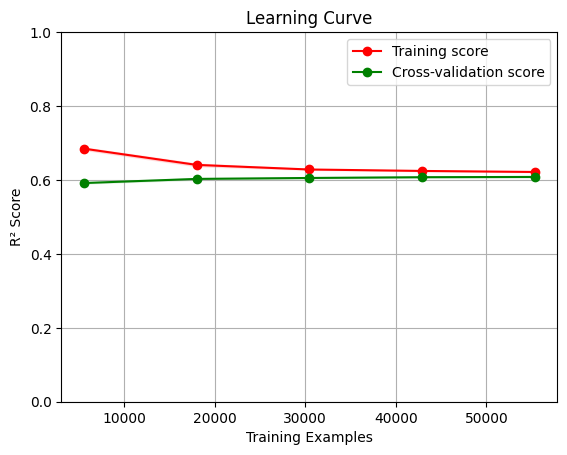

In [ ]:
plot_learning_curve(xgboost_regressor_2, x, y)

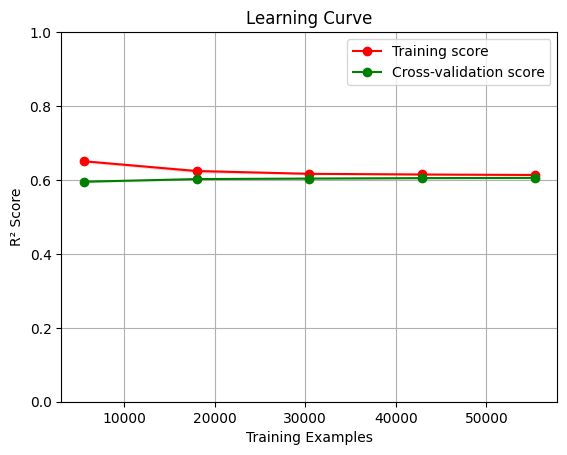

In [ ]:
plot_learning_curve(xgboost_regressor, x, y)

#### NN

##### NN1

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

nn_model_1 = Sequential()
nn_model_1.add(Input(shape=(x.shape[1],)))
nn_model_1.add(Dense(128, activation='relu'))
nn_model_1.add(Dense(64, activation='relu'))
nn_model_1.add(Dense(32, activation='relu'))
nn_model_1.add(Dense(16, activation='relu'))

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001, verbose=1)

def lr_schedule(epoch):
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 10
    lr = initial_lr * (drop ** (epoch // epochs_drop))
    return float(lr)  # Ensure the output is a float

lr_scheduler = LearningRateScheduler(lr_schedule)

# Early stopping to monitor validation loss (for RMSE)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

# Model checkpoint to save the best model based on validation loss
mc = ModelCheckpoint('cnn_best_model.keras', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
nn_model_1.compile(optimizer = 'adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping to monitor validation loss (for RMSE)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# Model checkpoint to save the best model based on validation loss
mc = ModelCheckpoint('cnn_model_1.keras', monitor='val_loss', mode='min', verbose=1, save_best_only=True)


In [ ]:
nn_model_1_hystory = nn_model_1.fit(x, y,
          epochs=10,
          validation_split = 0.2,
          batch_size = 32,
          verbose = 1,
          callbacks = [es,mc])

Epoch 1/10
4148/4152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 655728832.0000 - root_mean_squared_error: 25239.9199
Epoch 1: val_loss improved from inf to 440592928.00000, saving model to cnn_model_2.keras
4152/4152 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 655537664.0000 - root_mean_squared_error: 25236.3691 - val_loss: 440592928.0000 - val_root_mean_squared_error: 20990.3047
Epoch 2/10
4148/4152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 439247328.0000 - root_mean_squared_error: 20958.1738
Epoch 2: val_loss improved from 440592928.00000 to 437990560.00000, saving model to cnn_model_2.keras
4152/4152 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 439247200.0000 - root_mean_squared_error: 20958.1699 - val_loss: 437990560.0000 - val_root_mean_squared_error: 20928.2246
Epoch 3/10
4143/4152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 438236288.0000 - root_mean_squared_error: 20933.9844
Epoch 3: val_loss improved from 437990560.00000 to 437365920.00000, saving model to cnn_model_2.keras
4152/4152 ━━━

In [ ]:
nn_model_1.evaluate(x_test, y_test)

1038/1038 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 431150016.0000 - root_mean_squared_error: 20763.5879


[434137344.0, 20835.962890625]

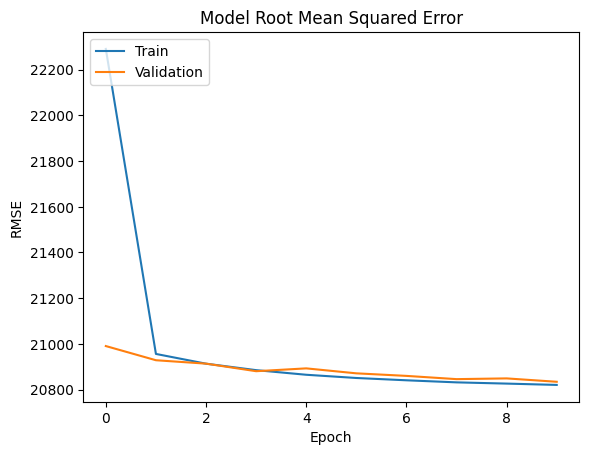

In [ ]:
plt.plot(nn_model_1_hystory.history['root_mean_squared_error'])
plt.plot(nn_model_1_hystory.history['val_root_mean_squared_error'])
plt.title('Model Root Mean Squared Error')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

nn_model_1 = Sequential()
nn_model_1.add(Input(shape=(x.shape[1],)))
nn_model_1.add(Dense(128, activation=LeakyReLU(negative_slope=0.01)))
nn_model_1.add(Dense(64, activation=LeakyReLU(negative_slope=0.01)))
nn_model_1.add(Dense(32, activation=LeakyReLU(negative_slope=0.01)))
nn_model_1.add(Dense(16, activation=LeakyReLU(negative_slope=0.01)))

* Leaky relu
* split 70 / 30

In [ ]:
from tensorflow.keras.optimizers import Adam
nn_model_1.compile(optimizer = Adam(0.001), loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
nn_model_1_hystory = nn_model_1.fit(x, y,
          epochs=30,
          validation_split = 0.3,
          batch_size = 32,
          verbose = 1,
          callbacks = [es,mc])

Epoch 1/30
3611/3633 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 423911552.0000 - root_mean_squared_error: 20588.8008
Epoch 1: val_loss improved from 433010816.00000 to 432461792.00000, saving model to cnn_model_1.keras
3633/3633 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 423926432.0000 - root_mean_squared_error: 20589.1641 - val_loss: 432461792.0000 - val_root_mean_squared_error: 20795.7148
Epoch 2/30
3614/3633 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 425564576.0000 - root_mean_squared_error: 20629.1445
Epoch 2: val_loss did not improve from 432461792.00000
3633/3633 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 425566592.0000 - root_mean_squared_error: 20629.1934 - val_loss: 432929120.0000 - val_root_mean_squared_error: 20806.9492
Epoch 3/30
3618/3633 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 428051904.0000 - root_mean_squared_error: 20689.2422
Epoch 3: val_loss did not improve from 432461792.00000
3633/3633 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 428043136.0000 - root_mean_squared_error: 2

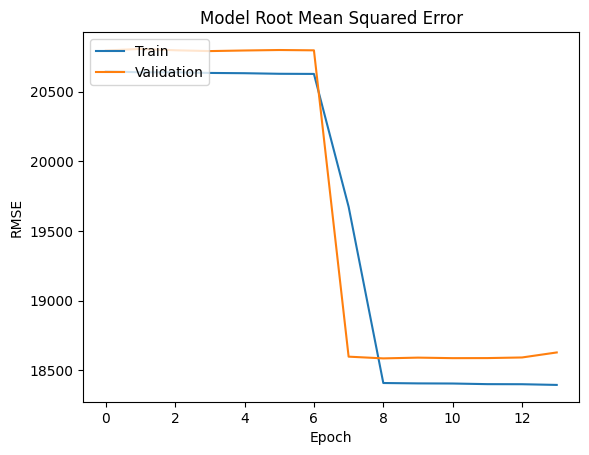

In [ ]:
plt.plot(nn_model_1_hystory.history['root_mean_squared_error'])
plt.plot(nn_model_1_hystory.history['val_root_mean_squared_error'])
plt.title('Model Root Mean Squared Error')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

* Batch norm
* More epochs
* Adjustable callback

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

nn_model_1 = Sequential()
nn_model_1.add(Input(shape=(x.shape[1],)))
nn_model_1.add(Dense(128, activation=LeakyReLU(negative_slope=0.01)))
# nn_model_1.add(BatchNormalization())
nn_model_1.add(Dropout(0.2))
nn_model_1.add(Dense(64, activation=LeakyReLU(negative_slope=0.01)))
# nn_model_1.add(BatchNormalization())
nn_model_1.add(Dropout(0.2))
nn_model_1.add(Dense(32, activation=LeakyReLU(negative_slope=0.01)))
# nn_model_1.add(BatchNormalization())
nn_model_1.add(Dropout(0.2))
nn_model_1.add(Dense(16, activation=LeakyReLU(negative_slope=0.01)))

In [ ]:
from tensorflow.keras.optimizers import Adam
nn_model_1.compile(optimizer = Adam(0.001), loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
nn_model_1_hystory = nn_model_1.fit(x, y,
          epochs=30,
          validation_split = 0.3,
          batch_size = 32,
          verbose = 1,
          callbacks = [es,mc,reduce_lr,lr_scheduler])

Epoch 1/30
3609/3633 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 504755360.0000 - root_mean_squared_error: 21657.9492
Epoch 1: val_loss improved from 1088991744.00000 to 184719504.00000, saving model to cnn_best_model.keras
3633/3633 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 503277792.0000 - root_mean_squared_error: 21626.1035 - val_loss: 184719504.0000 - val_root_mean_squared_error: 13591.1553 - learning_rate: 0.0010
Epoch 2/30
3627/3633 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 208119136.0000 - root_mean_squared_error: 14425.7793
Epoch 2: val_loss improved from 184719504.00000 to 181808800.00000, saving model to cnn_best_model.keras
3633/3633 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 208119968.0000 - root_mean_squared_error: 14425.8096 - val_loss: 181808800.0000 - val_root_mean_squared_error: 13483.6494 - learning_rate: 0.0010
Epoch 3/30
3631/3633 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 206245696.0000 - root_mean_squared_error: 14360.3369
Epoch 3: val_loss improved from 181808800.00000 

In [ ]:
nn_model_1.evaluate(x_test, y_test)

1038/1038 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 173046896.0000 - root_mean_squared_error: 13153.5371


[175459808.0, 13246.1240234375]

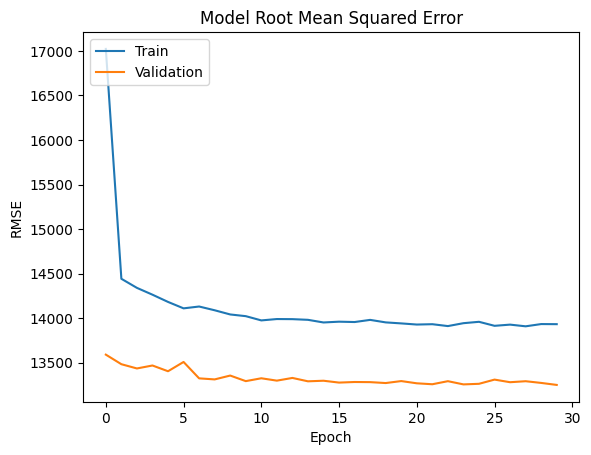

In [ ]:
plt.plot(nn_model_1_hystory.history['root_mean_squared_error'])
plt.plot(nn_model_1_hystory.history['val_root_mean_squared_error'])
plt.title('Model Root Mean Squared Error')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras.layers import Dense, Input, LeakyReLU, Dropout, BatchNormalization

# Build the model
nn_model_1 = Sequential()

# Input layer
nn_model_1.add(Input(shape=(x.shape[1],)))

# First dense layer with LeakyReLU and Dropout
nn_model_1.add(Dense(128))
nn_model_1.add(LeakyReLU(negative_slope=0.01))
nn_model_1.add(BatchNormalization())
nn_model_1.add(Dropout(0.2))

# Second dense layer with LeakyReLU and Dropout
nn_model_1.add(Dense(64))
nn_model_1.add(LeakyReLU(negative_slope=0.01))
nn_model_1.add(BatchNormalization())
nn_model_1.add(Dropout(0.2))

# Third dense layer with LeakyReLU and Dropout
nn_model_1.add(Dense(32))
nn_model_1.add(LeakyReLU(negative_slope=0.01))
nn_model_1.add(BatchNormalization())
nn_model_1.add(Dropout(0.2))

# Fourth dense layer with LeakyReLU
nn_model_1.add(Dense(16))
nn_model_1.add(LeakyReLU(negative_slope=0.01))

# Output layer (you can modify based on your output shape and activation)
nn_model_1.add(Dense(1, activation='linear'))  # For regression problems

# Compile the model (modify optimizer and loss function as needed)
nn_model_1.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Model summary
nn_model_1.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_47 (Dense)                     │ (None, 128)                 │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_29 (LeakyReLU)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_30 (LeakyReLU)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_31 (LeakyReLU)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_32 (LeakyReLU)           │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,513 (64.50 KB)

 Trainable params: 16,065 (62.75 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
from tensorflow.keras.optimizers import Adam
nn_model_1.compile(optimizer = Adam(0.001), loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
nn_model_1_hystory = nn_model_1.fit(x, y,
          epochs=40,
          validation_split = 0.3,
          batch_size = 32,
          verbose = 1,
          callbacks = [es,mc,reduce_lr,lr_scheduler])

Epoch 1/40
3618/3633 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1220329216.0000 - root_mean_squared_error: 34705.5117
Epoch 1: val_loss did not improve from 175592800.00000
3633/3633 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 1218354048.0000 - root_mean_squared_error: 34675.0156 - val_loss: 200392000.0000 - val_root_mean_squared_error: 14155.9883 - learning_rate: 0.0010
Epoch 2/40
3624/3633 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 216416544.0000 - root_mean_squared_error: 14710.5820
Epoch 2: val_loss did not improve from 175592800.00000
3633/3633 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 216405488.0000 - root_mean_squared_error: 14710.2061 - val_loss: 184124768.0000 - val_root_mean_squared_error: 13569.2578 - learning_rate: 0.0010
Epoch 3/40
3624/3633 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 208174736.0000 - root_mean_squared_error: 14427.6201
Epoch 3: val_loss did not improve from 175592800.00000
3633/3633 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 208162704.0000 - root_mean_squared_error

In [ ]:
nn_model_1.evaluate(x_test, y_test)

1038/1038 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 168296368.0000 - root_mean_squared_error: 12971.2549


[171290496.0, 13087.7998046875]

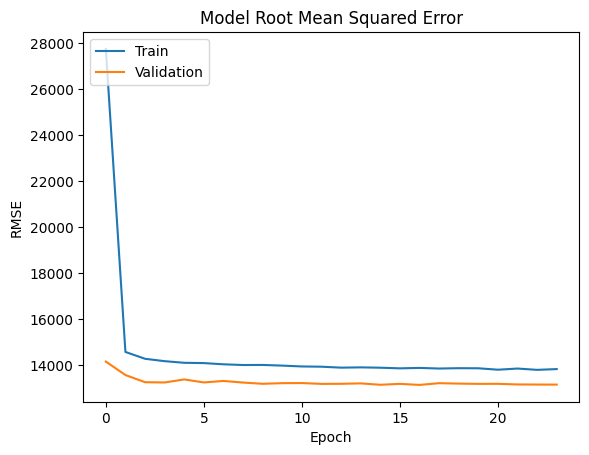

In [ ]:
plt.plot(nn_model_1_hystory.history['root_mean_squared_error'])
plt.plot(nn_model_1_hystory.history['val_root_mean_squared_error'])
plt.title('Model Root Mean Squared Error')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

* Dropout 0.1
* Batchsize 42

In [ ]:
from tensorflow.keras.layers import Dense, Input, LeakyReLU, Dropout, BatchNormalization

# Build the model
nn_model_1 = Sequential()

# Input layer
nn_model_1.add(Input(shape=(x.shape[1],)))

# First dense layer with LeakyReLU and Dropout
nn_model_1.add(Dense(128))
nn_model_1.add(LeakyReLU(negative_slope=0.01))
nn_model_1.add(BatchNormalization())
nn_model_1.add(Dropout(0.2))

# Second dense layer with LeakyReLU and Dropout
nn_model_1.add(Dense(64))
nn_model_1.add(LeakyReLU(negative_slope=0.01))
nn_model_1.add(BatchNormalization())
nn_model_1.add(Dropout(0.2))

# Third dense layer with LeakyReLU and Dropout
nn_model_1.add(Dense(32))
nn_model_1.add(LeakyReLU(negative_slope=0.01))
nn_model_1.add(BatchNormalization())
nn_model_1.add(Dropout(0.2))

# Fourth dense layer with LeakyReLU
nn_model_1.add(Dense(16))
nn_model_1.add(LeakyReLU(negative_slope=0.01))

# Output layer (you can modify based on your output shape and activation)
nn_model_1.add(Dense(1, activation='linear'))  # For regression problems

# Compile the model (modify optimizer and loss function as needed)
nn_model_1.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Model summary
nn_model_1.summary()


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_67 (Dense)                     │ (None, 128)                 │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_45 (LeakyReLU)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_68 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_46 (LeakyReLU)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_36               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_69 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_47 (LeakyReLU)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_37               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_70 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_48 (LeakyReLU)           │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_71 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,513 (64.50 KB)

 Trainable params: 16,065 (62.75 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
from tensorflow.keras.optimizers import Adam
nn_model_1.compile(optimizer = Adam(0.001), loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
nn_model_1_hystory = nn_model_1.fit(x, y,
          epochs=40,
          validation_split = 0.3,
          batch_size = 32,
          verbose = 1,
          callbacks = [es,mc,reduce_lr,lr_scheduler])

Epoch 1/40
2768/2768 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1360929920.0000 - root_mean_squared_error: 36808.8711
Epoch 1: val_loss did not improve from 172618576.00000
2768/2768 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 1360798464.0000 - root_mean_squared_error: 36806.9805 - val_loss: 240694800.0000 - val_root_mean_squared_error: 15514.3418 - learning_rate: 0.0010
Epoch 2/40
2759/2768 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 209181648.0000 - root_mean_squared_error: 14460.3359
Epoch 2: val_loss did not improve from 172618576.00000
2768/2768 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 209149376.0000 - root_mean_squared_error: 14459.2178 - val_loss: 179656272.0000 - val_root_mean_squared_error: 13403.5918 - learning_rate: 0.0010
Epoch 3/40
2757/2768 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 192473456.0000 - root_mean_squared_error: 13872.9004
Epoch 3: val_loss did not improve from 172618576.00000
2768/2768 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 192476048.0000 - root_mean_squared_error:

In [ ]:
nn_model_1.evaluate(x_test, y_test)

1038/1038 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 171760176.0000 - root_mean_squared_error: 13104.3350


[174667632.0, 13216.1884765625]

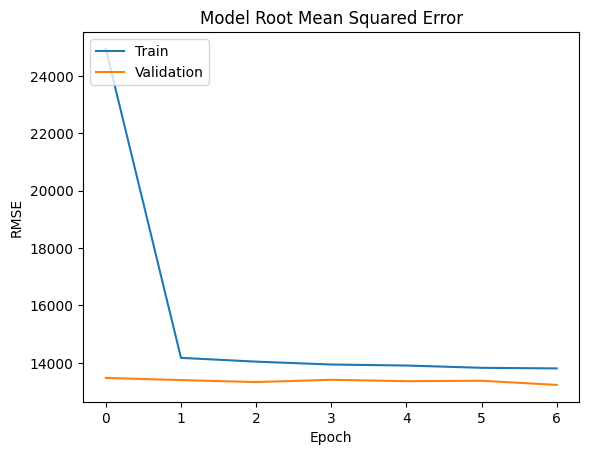

In [ ]:
plt.plot(nn_model_1_hystory.history['root_mean_squared_error'])
plt.plot(nn_model_1_hystory.history['val_root_mean_squared_error'])
plt.title('Model Root Mean Squared Error')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

##### NN2

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, LeakyReLU, BatchNormalization, Dropout

nn_model_2 = Sequential()
nn_model_2.add(Input(shape=(x.shape[1],)))
nn_model_2.add(Dense(128))
nn_model_2.add(LeakyReLU(negative_slope=0.01))
nn_model_2.add(BatchNormalization())
nn_model_2.add(Dropout(0.2))

nn_model_2.add(Dense(64))
nn_model_2.add(LeakyReLU(negative_slope=0.01))
nn_model_2.add(BatchNormalization())
nn_model_2.add(Dropout(0.2))

nn_model_2.add(Dense(32))
nn_model_2.add(LeakyReLU(negative_slope=0.01))
nn_model_2.add(BatchNormalization())
nn_model_2.add(Dropout(0.2))

nn_model_2.add(Dense(16))
nn_model_2.add(LeakyReLU(negative_slope=0.01))
nn_model_2.add(BatchNormalization())
nn_model_2.add(Dropout(0.2))

In [ ]:
nn_model_2.compile(optimizer = 'adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
nn_model_2_hystory = nn_model_2.fit(x, y,
          epochs=20,
          validation_split = 0.2,
          batch_size = 32,
          verbose = 1,
          callbacks = [es,mc])
          # callbacks = [es,mc,lr_scheduler])
# callbacks = [es,mc,reduce_lr,lr_scheduler])

Epoch 1/20
4146/4152 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1552608896.0000 - root_mean_squared_error: 39403.0273
Epoch 1: val_loss improved from 1555732096.00000 to 1555288960.00000, saving model to cnn_model_2.keras
4152/4152 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 1552606720.0000 - root_mean_squared_error: 39403.0000 - val_loss: 1555288960.0000 - val_root_mean_squared_error: 39437.1523
Epoch 2/20
4147/4152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1554370176.0000 - root_mean_squared_error: 39425.3320
Epoch 2: val_loss improved from 1555288960.00000 to 1554909312.00000, saving model to cnn_model_2.keras
4152/4152 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 1554365056.0000 - root_mean_squared_error: 39425.2695 - val_loss: 1554909312.0000 - val_root_mean_squared_error: 39432.3398
Epoch 3/20
4146/4152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1549869696.0000 - root_mean_squared_error: 39368.2031
Epoch 3: val_loss improved from 1554909312.00000 to 1554475008.00000, saving model to cnn_mo

In [ ]:
nn_model_2.evaluate(x_test, y_test)

1038/1038 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 431150016.0000 - root_mean_squared_error: 20763.5879


[434137344.0, 20835.962890625]

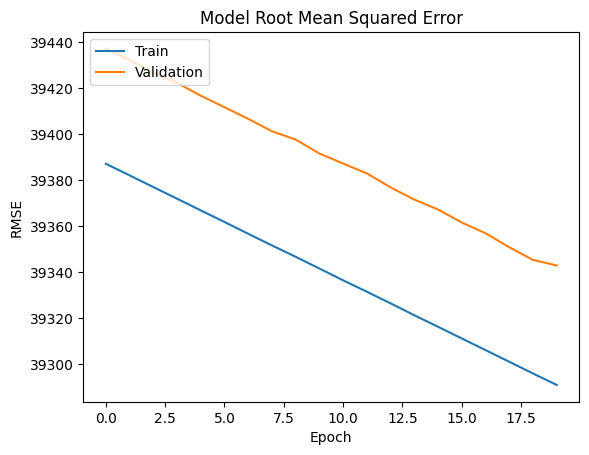

In [ ]:
plt.plot(nn_model_2_hystory.history['root_mean_squared_error'])
plt.plot(nn_model_2_hystory.history['val_root_mean_squared_error'])
plt.title('Model Root Mean Squared Error')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

* more epochs
* split 30%, 70%
* LR callbacks
* Hight LR 0.005

In [ ]:
ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001, verbose=1)

def lr_schedule(epoch):
    # initial_lr = 0.001
    initial_lr = 0.005
    drop = 0.5
    epochs_drop = 30
    lr = initial_lr * (drop ** (epoch // epochs_drop))
    return float(lr)  # Ensure the output is a float

lr_scheduler = LearningRateScheduler(lr_schedule)

# Early stopping to monitor validation loss (for RMSE)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# Model checkpoint to save the best model based on validation loss
mc = ModelCheckpoint('cnn_model_2.keras', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
nn_model_2_hystory = nn_model_2.fit(x, y,
          epochs=30,
          validation_split = 0.3,
          batch_size = 32,
          verbose = 1,
          callbacks = [es,mc,lr_scheduler,reduce_lr])

Epoch 1/30
3633/3633 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1541160320.0000 - root_mean_squared_error: 39256.9219
Epoch 1: val_loss improved from inf to 1553124736.00000, saving model to cnn_model_2.keras
3633/3633 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 1541159808.0000 - root_mean_squared_error: 39256.9141 - val_loss: 1553124736.0000 - val_root_mean_squared_error: 39409.7031 - learning_rate: 0.0050
Epoch 2/30
3627/3633 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1536005120.0000 - root_mean_squared_error: 39191.6328
Epoch 2: val_loss improved from 1553124736.00000 to 1550101376.00000, saving model to cnn_model_2.keras
3633/3633 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 1536008192.0000 - root_mean_squared_error: 39191.6719 - val_loss: 1550101376.0000 - val_root_mean_squared_error: 39371.3281 - learning_rate: 0.0050
Epoch 3/30
3613/3633 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1532280064.0000 - root_mean_squared_error: 39143.8984
Epoch 3: val_loss improved from 1550101376.00000 to 15486

KeyboardInterrupt: 

##### NN3
* added one mare layer
* increased learning curve

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, LeakyReLU, BatchNormalization, Dropout

nn_model_3 = Sequential()
nn_model_3.add(Input(shape=(x.shape[1],)))
nn_model_3.add(Dense(128))
nn_model_3.add(LeakyReLU(negative_slope=0.01))
nn_model_3.add(BatchNormalization())
nn_model_3.add(Dropout(0.2))

nn_model_3.add(Dense(64))
nn_model_3.add(LeakyReLU(negative_slope=0.01))
nn_model_3.add(BatchNormalization())
nn_model_3.add(Dropout(0.2))

nn_model_3.add(Dense(64))
nn_model_3.add(LeakyReLU(negative_slope=0.01))
nn_model_3.add(BatchNormalization())
nn_model_3.add(Dropout(0.2))

nn_model_3.add(Dense(32))
nn_model_3.add(LeakyReLU(negative_slope=0.01))
nn_model_3.add(BatchNormalization())
nn_model_3.add(Dropout(0.2))

nn_model_3.add(Dense(16))
nn_model_3.add(LeakyReLU(negative_slope=0.01))
nn_model_3.add(BatchNormalization())
nn_model_3.add(Dropout(0.2))


In [ ]:
nn_model_3.compile(optimizer = 'adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001, verbose=1)

def lr_schedule(epoch):
    # initial_lr = 0.001
    initial_lr = 0.003
    drop = 0.5
    epochs_drop = 30
    lr = initial_lr * (drop ** (epoch // epochs_drop))
    return float(lr)  # Ensure the output is a float

lr_scheduler = LearningRateScheduler(lr_schedule)

# Early stopping to monitor validation loss (for RMSE)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# Model checkpoint to save the best model based on validation loss
mc = ModelCheckpoint('cnn_model_3.keras', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
nn_model_3_hystory = nn_model_3.fit(x, y,
          epochs=20,
          validation_split = 0.2,
          batch_size = 32,
          verbose = 1,
          # callbacks = [es,mc])
          # callbacks = [es,mc,lr_scheduler])
callbacks = [es,mc,reduce_lr,lr_scheduler])

Epoch 1/20
4151/4152 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1548810240.0000 - root_mean_squared_error: 39354.8125
Epoch 1: val_loss improved from inf to 1554949632.00000, saving model to cnn_model_3.keras
4152/4152 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 1548811520.0000 - root_mean_squared_error: 39354.8281 - val_loss: 1554949632.0000 - val_root_mean_squared_error: 39432.8516 - learning_rate: 0.0030
Epoch 2/20
4145/4152 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1546447232.0000 - root_mean_squared_error: 39324.6172
Epoch 2: val_loss improved from 1554949632.00000 to 1553823872.00000, saving model to cnn_model_3.keras
4152/4152 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 1546454528.0000 - root_mean_squared_error: 39324.7109 - val_loss: 1553823872.0000 - val_root_mean_squared_error: 39418.5742 - learning_rate: 0.0030
Epoch 3/20
4146/4152 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1551671296.0000 - root_mean_squared_error: 39391.0781
Epoch 3: val_loss improved from 1553823872.00000 to 15524

In [ ]:
nn_model_3.evaluate(x_test, y_test)

1038/1038 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 1524084864.0000 - root_mean_squared_error: 39038.6250


[1530097024.0, 39116.453125]

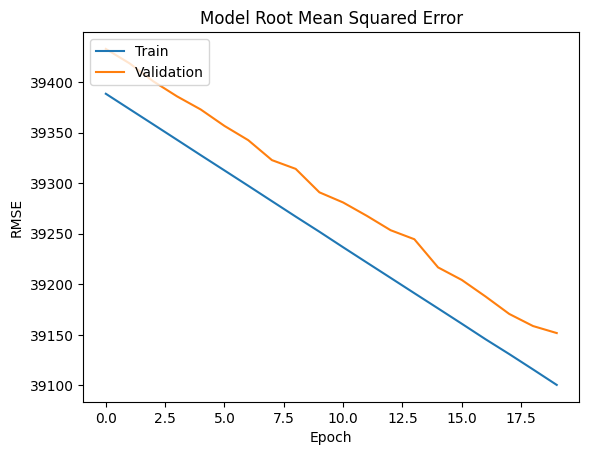

In [ ]:
plt.plot(nn_model_3_hystory.history['root_mean_squared_error'])
plt.plot(nn_model_3_hystory.history['val_root_mean_squared_error'])
plt.title('Model Root Mean Squared Error')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### TAB NET

In [ ]:
pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.metrics import mean_squared_error, r2_score
from torch.optim.lr_scheduler import StepLR

# Prepare your data (assuming you have defined x_train, y_train, x_test, y_test)

# Standardize features (optional)
# scaler = StandardScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test)

# Initialize the model
tabnet_model = TabNetRegressor(
    n_d=8,
    n_a=8,
    n_steps=3,
    gamma=1.3,
    n_independent=2,
    n_shared=2,
    momentum=0.3,
    lambda_sparse=1e-5,
    clip_value=2.0,
    scheduler_params={"step_size": 100, "gamma": 0.95},
    scheduler_fn=StepLR,  # Use the function reference here
    verbose=10,
)

# Train the model
tabnet_model.fit(
    x_train.values,  # Convert to NumPy array
    y_train.values.reshape(-1, 1),  # Reshape to 2D array
    eval_set=[(x_test.values, y_test.values.reshape(-1, 1))],  # Reshape for eval set
    eval_metric=['mse'],
    max_epochs=100,
    patience=20,
    batch_size=1024,
    virtual_batch_size=128,
)

# Predict on the test set
y_pred = tabnet_model.predict(x_test.values)

# Calculate RMSE and R²
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse}')
print(f'R²: {r2}')

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1541643945.67442| val_0_mse: 1522464601.59026|  0:00:17s
epoch 10 | loss: 299007733.2093| val_0_mse: 251032300.06091|  0:01:45s
epoch 20 | loss: 173234995.47287| val_0_mse: 175911468.10491|  0:03:13s
epoch 30 | loss: 171090633.92248| val_0_mse: 172808679.62358|  0:04:45s
epoch 40 | loss: 170262774.82171| val_0_mse: 172660322.35026|  0:06:12s
epoch 50 | loss: 169178741.82946| val_0_mse: 174018196.5454|  0:07:39s

Early stopping occurred at epoch 56 with best_epoch = 36 and best_val_0_mse = 171983348.3578


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


RMSE: 13114.24219533116
R²: 0.603892801741859


#### CAT

In [ ]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 132838 entries, 56463 to 69412
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   brand                  132838 non-null  object  
 1   milage                 132838 non-null  float64 
 2   fuel_type              132838 non-null  object  
 3   horsepower             132838 non-null  float64 
 4   displacement           132838 non-null  float64 
 5   is_luxury              132838 non-null  float64 
 6   is_discontinued        132838 non-null  float64 
 7   parent_group           132838 non-null  object  
 8   region                 132838 non-null  object  
 9   is_electric            132838 non-null  float64 
 10  car_age                132838 non-null  float64 
 11  car_age_bucket         132838 non-null  category
 12  milage_bucket          132838 non-null  category
 13  power_to_displacement  132838 non-null  float64 
 14  transmission_type     

In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.7 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

def train_and_evaluate_catboost_regressor(x_train, y_train, x_test, y_test, cat_features,
                                          iterations=1000, depth=10, learning_rate=0.05,
                                          early_stopping_rounds=100, verbose=100):
    """
    Train a CatBoostRegressor model with early stopping and evaluate using RMSE.

    Parameters:
    - X_train: DataFrame, Features for training.
    - y_train: Series, Target variable for training.
    - X_test: DataFrame, Features for testing.
    - y_test: Series, Target variable for testing.
    - cat_features: List, Categorical feature names or indices.
    - iterations: Int, Number of boosting iterations (default: 300).
    - depth: Int, Depth of the trees (default: 10).
    - learning_rate: Float, Learning rate (default: 0.1).
    - early_stopping_rounds: Int, Rounds with no improvement to stop training (default: 50).
    - verbose: Int, Verbosity during training (default: 100).

    Returns:
    - model: Trained CatBoostRegressor model.
    - rmse: Float, Root Mean Squared Error on the test set.
    """
    # Initialize the CatBoostRegressor
    model = CatBoostRegressor(
        iterations=iterations,
        learning_rate=learning_rate,
        depth=depth,
        cat_features=cat_features,  # Specify categorical features
        verbose=verbose             # Print progress every 'verbose' iterations
    )

    # Train the model with early stopping
    model.fit(x_train, y_train,
              eval_set=(x_test, y_test),
              early_stopping_rounds=early_stopping_rounds,
              use_best_model=True)

    # Predict on the test set
    y_pred = model.predict(x_test)

    # Calculate RMSE using the new recommended way
    rmse = mean_squared_error(y_test, y_pred, squared=False)  # Direct calculation of RMSE
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

    return model, rmse

In [ ]:
cat_features = ['brand', 'fuel_type', 'parent_group', 'region',
                'car_age_bucket', 'milage_bucket', 'transmission_type',
                'ext_col_simplified', 'int_col_simplified']

# Convert categorical columns to category type
for col in cat_features:
    if col in x_train.columns:
        x_train[col] = x_train[col].astype('category')
    if col in x_test.columns:
        x_test[col] = x_test[col].astype('category')

In [ ]:
model_cat, rmse = train_and_evaluate_catboost_regressor(x_train, y_train, x_test, y_test, cat_features,iterations=1000, depth=10, learning_rate=0.05,
                                          early_stopping_rounds=100, verbose=100)

0:	learn: 20259.9054799	test: 20262.5233769	best: 20262.5233769 (0)	total: 509ms	remaining: 8m 28s
100:	learn: 12776.8216677	test: 13036.7982838	best: 13036.7982838 (100)	total: 51.5s	remaining: 7m 38s
200:	learn: 12569.4623152	test: 12981.9925445	best: 12981.9106742 (199)	total: 1m 46s	remaining: 7m 3s
300:	learn: 12379.0611580	test: 12962.4072948	best: 12961.9086819 (288)	total: 2m 40s	remaining: 6m 13s
400:	learn: 12215.9220232	test: 12954.6093120	best: 12954.5230520 (399)	total: 3m 35s	remaining: 5m 22s
500:	learn: 12070.6034036	test: 12954.4518573	best: 12953.3226122 (425)	total: 4m 31s	remaining: 4m 30s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 12953.32261
bestIteration = 425

Shrink model to first 426 iterations.
Root Mean Squared Error (RMSE): 12953.3226


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

Root Mean Squared Error (RMSE): 12953.3226


* depth 10 -> 8
* L2 regularization
* LR 0.05 -> 0.03

In [ ]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

def train_and_evaluate_catboost_regressor(x_train, y_train, x_test, y_test, cat_features, iterations=300, depth=10, learning_rate=0.05, l2_leaf_reg=3.0, early_stopping_rounds=50):
    # Define the CatBoost Regressor with specified parameters
    model_cat = CatBoostRegressor(
        iterations=iterations,
        depth=depth,
        random_state=42,
        l2_leaf_reg=l2_leaf_reg,
        learning_rate=learning_rate,
        cat_features=cat_features,
        eval_metric='RMSE',
        early_stopping_rounds=early_stopping_rounds,
        verbose=100  # Adjust verbosity as needed
    )

    # Fit the model on the training data
    model_cat.fit(x_train, y_train, eval_set=(x_test, y_test))

    # Predict on the test set
    y_pred = model_cat.predict(x_test)

    # Calculate RMSE
    rmse = mean_squared_error(y_test, y_pred, squared=False)  # squared=False gives RMSE

    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

    return model_cat, rmse


In [ ]:
model_cat_2, rmse = train_and_evaluate_catboost_regressor(x_train, y_train, x_test, y_test, cat_features, iterations=1000, depth=8, learning_rate=0.03,
                                          l2_leaf_reg=3.0, early_stopping_rounds=50)

0:	learn: 20489.4944879	test: 20491.6265192	best: 20491.6265192 (0)	total: 927ms	remaining: 15m 25s
100:	learn: 13108.0170876	test: 13207.8987752	best: 13207.8987752 (100)	total: 37.9s	remaining: 5m 37s
200:	learn: 12894.1193242	test: 13051.9715516	best: 13051.9715516 (200)	total: 1m 9s	remaining: 4m 37s
300:	learn: 12803.5527541	test: 13010.1826648	best: 13010.1826648 (300)	total: 1m 43s	remaining: 4m
400:	learn: 12735.4957639	test: 12983.7365974	best: 12983.7365974 (400)	total: 2m 15s	remaining: 3m 22s
500:	learn: 12663.3030584	test: 12967.4744011	best: 12967.4528654 (499)	total: 2m 50s	remaining: 2m 49s
600:	learn: 12606.6762919	test: 12958.3739906	best: 12958.3739906 (600)	total: 3m 24s	remaining: 2m 16s
700:	learn: 12557.2214138	test: 12952.9808675	best: 12952.9808675 (700)	total: 3m 59s	remaining: 1m 42s
800:	learn: 12500.2516404	test: 12946.3132703	best: 12946.3132703 (800)	total: 4m 33s	remaining: 1m 7s
900:	learn: 12451.3134578	test: 12943.3977403	best: 12943.3726552 (898)	tot

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
model_cat_2, rmse = train_and_evaluate_catboost_regressor(x_train, y_train, x_test, y_test, cat_features, iterations=1000, depth=8, learning_rate=0.03,
                                          l2_leaf_reg=3.0, early_stopping_rounds=50)

In [ ]:
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

Root Mean Squared Error (RMSE): 12940.1526


In [ ]:
model_cat_2, rmse = train_and_evaluate_catboost_regressor(x_train, y_train, x_test, y_test, cat_features, iterations=1300, depth=8, learning_rate=0.03,
                                          l2_leaf_reg=3.0, early_stopping_rounds=50)

* Instead of a simple train-test split,  K-Fold cross-validation to ensure your model is robust and not overfitting to a specific train-test split.

In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

def train_and_evaluate_catboost_regressor(x_train, y_train, x_test, y_test, cat_features, iterations=1000, depth=8, learning_rate=0.03,
                                          l2_leaf_reg=3.0, early_stopping_rounds=50, n_splits=5):
    # K-Fold Cross Validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    rmse_scores = []

    for train_index, val_index in kf.split(x_train):
        x_train_fold, x_val_fold = x_train.iloc[train_index], x_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        # Define the CatBoost Regressor with specified parameters
        model_cat = CatBoostRegressor(
            iterations=iterations,
            depth=depth,
            learning_rate=learning_rate,
            l2_leaf_reg=l2_leaf_reg,
            random_state=42,
            cat_features=cat_features,
            eval_metric='RMSE',
            early_stopping_rounds=early_stopping_rounds,
            verbose=100
        )

        # Fit the model on the training fold
        model_cat.fit(x_train_fold, y_train_fold, eval_set=(x_val_fold, y_val_fold))

        # Predict on the validation fold
        y_val_pred = model_cat.predict(x_val_fold)

        # Calculate RMSE
        rmse = mean_squared_error(y_val_fold, y_val_pred, squared=False)
        rmse_scores.append(rmse)
        print(f'Fold RMSE: {rmse:.4f}')

    print(f'Average RMSE: {sum(rmse_scores) / len(rmse_scores):.4f}')

    # Fit the model on the full training data
    model_cat.fit(x_train, y_train, eval_set=(x_test, y_test))

    # Predict on the test set
    y_pred = model_cat.predict(x_test)

    # Calculate test RMSE
    test_rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f'Root Mean Squared Error (RMSE) on Test Set: {test_rmse:.4f}')

    return model_cat, test_rmse

In [ ]:
model_cat_2, rmse = train_and_evaluate_catboost_regressor(x_train, y_train, x_test, y_test, cat_features, iterations=1000, depth=8, learning_rate=0.03,
                                          l2_leaf_reg=3.0, early_stopping_rounds=100)

0:	learn: 20489.7663407	test: 20471.2563803	best: 20471.2563803 (0)	total: 525ms	remaining: 8m 44s
100:	learn: 13117.6623515	test: 13088.5990767	best: 13088.5990767 (100)	total: 28.2s	remaining: 4m 11s
200:	learn: 12898.0365719	test: 12925.6709791	best: 12925.6709791 (200)	total: 53.2s	remaining: 3m 31s
300:	learn: 12806.6252770	test: 12887.0528274	best: 12886.9988146 (299)	total: 1m 23s	remaining: 3m 12s
400:	learn: 12728.1492347	test: 12860.3134714	best: 12860.3134714 (400)	total: 1m 49s	remaining: 2m 44s
500:	learn: 12656.7654146	test: 12843.2867981	best: 12843.2867981 (500)	total: 2m 16s	remaining: 2m 15s
600:	learn: 12601.9613912	test: 12833.4797136	best: 12833.4797136 (600)	total: 2m 44s	remaining: 1m 49s
700:	learn: 12552.5035379	test: 12828.5844191	best: 12828.5844191 (700)	total: 3m 11s	remaining: 1m 21s
800:	learn: 12495.2963293	test: 12823.0729804	best: 12822.9539312 (795)	total: 3m 39s	remaining: 54.5s
900:	learn: 12447.2457995	test: 12821.5335180	best: 12821.3028357 (857)	

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 12816.9555
0:	learn: 20472.4901334	test: 20567.9922396	best: 20567.9922396 (0)	total: 289ms	remaining: 4m 49s
100:	learn: 13105.9640572	test: 13134.2996042	best: 13134.2996042 (100)	total: 24.4s	remaining: 3m 37s
200:	learn: 12890.5316818	test: 12962.9644963	best: 12962.9644963 (200)	total: 50.3s	remaining: 3m 19s
300:	learn: 12796.9754291	test: 12917.1907962	best: 12917.1907962 (300)	total: 1m 16s	remaining: 2m 57s
400:	learn: 12727.4904988	test: 12897.0783550	best: 12897.0783550 (400)	total: 1m 41s	remaining: 2m 32s
500:	learn: 12664.5428119	test: 12887.7749084	best: 12887.7749084 (500)	total: 2m 8s	remaining: 2m 8s
600:	learn: 12616.4656175	test: 12883.7399136	best: 12883.7399136 (600)	total: 2m 34s	remaining: 1m 42s
700:	learn: 12565.3579624	test: 12878.1383886	best: 12878.1383886 (700)	total: 3m	remaining: 1m 16s
800:	learn: 12520.4792907	test: 12873.7760165	best: 12873.7760165 (800)	total: 3m 25s	remaining: 51.1s
900:	learn: 12468.0033366	test: 12870.7573258	best: 1287

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 12867.5137
0:	learn: 20492.7044463	test: 20480.8081863	best: 20480.8081863 (0)	total: 286ms	remaining: 4m 45s
100:	learn: 13089.4554893	test: 13184.0369621	best: 13184.0369621 (100)	total: 26.1s	remaining: 3m 52s
200:	learn: 12867.7405254	test: 13039.5168189	best: 13039.5168189 (200)	total: 51.2s	remaining: 3m 23s
300:	learn: 12773.6475811	test: 13002.4734678	best: 13002.4734678 (300)	total: 1m 15s	remaining: 2m 54s
400:	learn: 12695.0055060	test: 12978.6598239	best: 12978.6598239 (400)	total: 1m 42s	remaining: 2m 33s
500:	learn: 12624.4824278	test: 12962.0490368	best: 12962.0292974 (498)	total: 2m 8s	remaining: 2m 8s
600:	learn: 12567.0964460	test: 12951.1956476	best: 12951.1956476 (600)	total: 2m 35s	remaining: 1m 43s
700:	learn: 12512.6521637	test: 12946.0757919	best: 12946.0757919 (700)	total: 3m 2s	remaining: 1m 17s
800:	learn: 12466.5058470	test: 12940.0434106	best: 12940.0434106 (800)	total: 3m 29s	remaining: 52s
900:	learn: 12416.6941727	test: 12937.9283616	best: 129

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 12936.4193
0:	learn: 20509.1701038	test: 20409.5031169	best: 20409.5031169 (0)	total: 278ms	remaining: 4m 37s
100:	learn: 13095.4639121	test: 13153.5802205	best: 13153.5802205 (100)	total: 26.8s	remaining: 3m 58s
200:	learn: 12877.9173007	test: 13008.9674354	best: 13008.9674354 (200)	total: 52.6s	remaining: 3m 28s
300:	learn: 12782.4954645	test: 12971.5393037	best: 12971.5393037 (300)	total: 1m 19s	remaining: 3m 4s
400:	learn: 12706.9109855	test: 12947.5488393	best: 12947.5207501 (398)	total: 1m 46s	remaining: 2m 38s
500:	learn: 12631.8758287	test: 12936.4404712	best: 12936.4404712 (500)	total: 2m 12s	remaining: 2m 12s
600:	learn: 12569.5258261	test: 12928.0843765	best: 12928.0738321 (599)	total: 2m 39s	remaining: 1m 46s
700:	learn: 12517.0227024	test: 12923.9193731	best: 12923.9193731 (700)	total: 3m 7s	remaining: 1m 19s
800:	learn: 12469.3902065	test: 12920.7071744	best: 12920.5866346 (793)	total: 3m 33s	remaining: 53s
900:	learn: 12424.0057852	test: 12917.8005006	best: 12

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 12912.9162
0:	learn: 20482.4775222	test: 20517.9196843	best: 20517.9196843 (0)	total: 276ms	remaining: 4m 35s
100:	learn: 13078.7860693	test: 13208.9803837	best: 13208.9803837 (100)	total: 25.9s	remaining: 3m 50s
200:	learn: 12858.6325026	test: 13064.4441095	best: 13064.4441095 (200)	total: 52s	remaining: 3m 26s
300:	learn: 12769.3293618	test: 13023.7470891	best: 13023.7470891 (300)	total: 1m 17s	remaining: 3m 1s
400:	learn: 12698.5802069	test: 13001.9168247	best: 13001.9168247 (400)	total: 1m 42s	remaining: 2m 33s
500:	learn: 12627.7614990	test: 12986.9005906	best: 12986.8561971 (497)	total: 2m 9s	remaining: 2m 8s
600:	learn: 12571.4571482	test: 12978.0534610	best: 12978.0534610 (600)	total: 2m 34s	remaining: 1m 42s
700:	learn: 12523.0488252	test: 12974.3275179	best: 12974.2030228 (680)	total: 2m 59s	remaining: 1m 16s
800:	learn: 12474.4974872	test: 12970.8888074	best: 12970.8888074 (800)	total: 3m 25s	remaining: 51.1s
900:	learn: 12422.2577729	test: 12967.7035161	best: 129

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 12963.5868
Average RMSE: 12899.4783
0:	learn: 20489.4944879	test: 20491.6265192	best: 20491.6265192 (0)	total: 344ms	remaining: 5m 43s
100:	learn: 13108.0170876	test: 13207.8987752	best: 13207.8987752 (100)	total: 31.5s	remaining: 4m 40s
200:	learn: 12894.1193242	test: 13051.9715516	best: 13051.9715516 (200)	total: 1m 4s	remaining: 4m 17s
300:	learn: 12803.5527541	test: 13010.1826648	best: 13010.1826648 (300)	total: 1m 35s	remaining: 3m 41s
400:	learn: 12735.4957639	test: 12983.7365974	best: 12983.7365974 (400)	total: 2m 6s	remaining: 3m 8s
500:	learn: 12663.3030584	test: 12967.4744011	best: 12967.4528654 (499)	total: 2m 40s	remaining: 2m 39s
600:	learn: 12606.6762919	test: 12958.3739906	best: 12958.3739906 (600)	total: 3m 11s	remaining: 2m 7s
700:	learn: 12557.2214138	test: 12952.9808675	best: 12952.9808675 (700)	total: 3m 43s	remaining: 1m 35s
800:	learn: 12500.2516404	test: 12946.3132703	best: 12946.3132703 (800)	total: 4m 17s	remaining: 1m 4s
900:	learn: 12451.3134578	te

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

Root Mean Squared Error (RMSE): 12939.6830


### Models New features

#### Forest

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import learning_curve, train_test_split

import xgboost as xgb

In [ ]:
# Assuming you have your training data (x_train, y_train) and test data (x_test, y_test)

# Initialize and fit the model
dt_regressor = DecisionTreeRegressor(min_samples_split=10, random_state=42)
dt_regressor.fit(x_train, y_train)

# Predict on the test set
y_pred = dt_regressor.predict(x_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Calculate R² Score
r_squared = r2_score(y_test, y_pred)
print(f"R² Score: {r_squared:.2f}")



RMSE: 17438.28
Mean Absolute Error (MAE): 12363.19
R² Score: 0.30


In [ ]:
# Initialize the RandomForestRegressor
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
random_forest.fit(x_train, y_train)

# Make predictions
predictions = random_forest.predict(x_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f'MSE: {mse}, R²: {r2}')

RMSE: 17438.28
MSE: 178950866.98059857, R²: 0.5878454093237009


### Predictions

In [ ]:
my_best_classifier = model_cat_2

X_test = test_data.drop(columns=['id'])
y_pred = my_best_classifier.predict(X_test)

# Create a DataFrame with 'ID' and predicted 'Overall_Experience'
predictions_df = pd.DataFrame({
    'id': test_data['id'],
    'price': y_pred
})

# Print or use predictions_df as needed
print(predictions_df)

predictions_df.to_csv('predictions_cat_2.csv', index=False)

            id         price
0       188533  19465.303510
1       188534  53399.857607
2       188535  49951.488166
3       188536  29774.026458
4       188537  31205.262863
...        ...           ...
125685  314218  22808.326475
125686  314219  42521.406273
125687  314220  20202.344232
125688  314221  15339.136740
125689  314222  34541.973007

[125690 rows x 2 columns]


In [ ]:
my_best_classifier = random_forest

X_test = test_data.drop(columns=['id'])
y_pred = my_best_classifier.predict(X_test)

# Create a DataFrame with 'ID' and predicted 'Overall_Experience'
predictions_df = pd.DataFrame({
    'id': test_data['id'],
    'price': y_pred
})

# Print or use predictions_df as needed
print(predictions_df)

predictions_df.to_csv('predictions.csv', index=False)

            id     price
0       188533  22593.51
1       188534  53435.92
2       188535  52244.56
3       188536  28665.61
4       188537  32647.27
...        ...       ...
125685  314218  20630.38
125686  314219  46157.00
125687  314220  18404.80
125688  314221  23947.41
125689  314222  33858.87

[125690 rows x 2 columns]


In [ ]:
print("Shape of y_pred:", y_pred.shape)

Shape of y_pred: (125690, 16)


### Prediction NN

In [ ]:
# Get predictions
y_pred = my_best_classifier.predict(X_test)

# Print the shape to confirm
print("Shape of y_pred:", y_pred.shape)

# If you want only the first output
y_pred = y_pred[:, 0]  # Get only the first column

# Create a DataFrame with 'ID' and predicted 'price'
predictions_df = pd.DataFrame({
    'id': test_data['id'],
    'price': y_pred
})

# Save predictions to a CSV file
predictions_df.to_csv('predictions.csv', index=False)

3928/3928 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
Shape of y_pred: (125690, 16)


### Prediction TabNet

In [ ]:
# Drop the 'id' column from test data to get features
X_test = test_data.drop(columns=['id'])

# Predict car prices using the trained TabNet model
y_pred = tabnet_model.predict(X_test.values)  # Ensure you use '.values' for TabNet compatibility

# Create a DataFrame with 'id' and predicted 'price'
predictions_df = pd.DataFrame({
    'id': test_data['id'],
    'price': y_pred.flatten()  # Flatten to ensure y_pred is a 1D array
})

# Print or use predictions_df as needed
print(predictions_df)

# Save predictions to a CSV file
predictions_df.to_csv('predictions.csv', index=False)

            id         price
0       188533  19558.263672
1       188534  54333.187500
2       188535  50387.210938
3       188536  36004.718750
4       188537  31663.271484
...        ...           ...
125685  314218  23490.521484
125686  314219  47917.156250
125687  314220  20659.015625
125688  314221  16639.470703
125689  314222  34941.144531

[125690 rows x 2 columns]
